<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [20]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [21]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [20]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [21]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="8",
                             total_timesteps=6000000)

load
Logging to ppo/8_9
----------------------------------
| time/              |           |
|    fps             | 118       |
|    iterations      | 1         |
|    time_elapsed    | 17        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.7735156 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017141536 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.000815   |
|    learning_rate        | 0.00025     |
|    loss                 | 6.97        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 12          |
|    time_elapsed         | 217         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.020796824 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | -0.0324     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.29        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0201     |
|    reward               | -0.19528693 |
|    std                  | 1.02        |
|    value_loss           | 20.5        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2924221.42
total_reward: 1924221.42
total_cost: 316090.63
total_trades: 78547
Sharpe: 0.60

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 22          |
|    time_elapsed         | 400         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.023324816 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.2       |
|    explained_variance   | 0.0294      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0167     |
|    reward               | 3.5745618   |
|    std                  | 1.04        |
|    value_loss           | 30          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 32          |
|    time_elapsed         | 582         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.021115389 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.0256      |
|    learning_rate        | 0.00025     |
|    loss                 | 12          |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0166     |
|    reward               | -0.0691202  |
|    std                  | 1.06        |
|    value_loss           | 21.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 42          |
|    time_elapsed         | 763         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.015614071 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.00234     |
|    learning_rate        | 0.00025     |
|    loss                 | 24          |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.015      |
|    reward               | -0.47437537 |
|    std                  | 1.08        |
|    value_loss           | 98          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 52          |
|    time_elapsed         | 946         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.031677667 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | -0.00533    |
|    learning_rate        | 0.00025     |
|    loss                 | 44.5        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0115     |
|    reward               | -3.9148052  |
|    std                  | 1.1         |
|    value_loss           | 79          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 53       

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 62          |
|    time_elapsed         | 1133        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.026972776 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0341      |
|    learning_rate        | 0.00025     |
|    loss                 | 31.5        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00905    |
|    reward               | 6.9173956   |
|    std                  | 1.12        |
|    value_loss           | 71.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 63       

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 72         |
|    time_elapsed         | 1316       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.03725774 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.9      |
|    explained_variance   | 0.0347     |
|    learning_rate        | 0.00025    |
|    loss                 | 23.1       |
|    n_updates            | 710        |
|    policy_gradient_loss | -0.00916   |
|    reward               | -10.48139  |
|    std                  | 1.14       |
|    value_loss           | 33.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 73          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 82          |
|    time_elapsed         | 1498        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.02592865  |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.4       |
|    explained_variance   | 0.0252      |
|    learning_rate        | 0.00025     |
|    loss                 | 27.5        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00694    |
|    reward               | -0.78827435 |
|    std                  | 1.16        |
|    value_loss           | 64.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 83    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 92          |
|    time_elapsed         | 1681        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.032300938 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.8       |
|    explained_variance   | 0.0545      |
|    learning_rate        | 0.00025     |
|    loss                 | 49.2        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00735    |
|    reward               | -1.8817426  |
|    std                  | 1.18        |
|    value_loss           | 82          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 93       

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 102         |
|    time_elapsed         | 1864        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.022246547 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.4       |
|    explained_variance   | 0.052       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.015      |
|    reward               | -1.1628128  |
|    std                  | 1.2         |
|    value_loss           | 74.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 3060597.80
total_reward: 2060597.80
total_cost: 312772.04
total_trades: 73302
Sharpe: 0.615
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 112         |
|    time_elapsed         | 2046        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.055083513 |
|    clip_fraction        | 0.394       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.9       |
|    explained_variance   | 0.00795     |
|    learning_rate        | 0.00025     |
|    loss                 | 33.6        |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.000717   |
|    reward               | -1.3186854  |
|    std                  | 1.22        |
|    value_loss           | 72.6        |
----------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 122        |
|    time_elapsed         | 2228       |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.03347399 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.5      |
|    explained_variance   | 0.0323     |
|    learning_rate        | 0.00025    |
|    loss                 | 40.8       |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.0123    |
|    reward               | 0.9244238  |
|    std                  | 1.25       |
|    value_loss           | 61.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 123         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 132         |
|    time_elapsed         | 2413        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.024818372 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -48         |
|    explained_variance   | -0.00929    |
|    learning_rate        | 0.00025     |
|    loss                 | 7.23        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00388    |
|    reward               | 2.200253    |
|    std                  | 1.27        |
|    value_loss           | 23.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 133   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 142        |
|    time_elapsed         | 2595       |
|    total_timesteps      | 290816     |
| train/                  |            |
|    approx_kl            | 0.04392592 |
|    clip_fraction        | 0.381      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.4      |
|    explained_variance   | -0.00524   |
|    learning_rate        | 0.00025    |
|    loss                 | 28.2       |
|    n_updates            | 1410       |
|    policy_gradient_loss | 0.00591    |
|    reward               | -1.4454795 |
|    std                  | 1.29       |
|    value_loss           | 43.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 143         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 152        |
|    time_elapsed         | 2778       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.03080684 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.8      |
|    explained_variance   | 0.0751     |
|    learning_rate        | 0.00025    |
|    loss                 | 22.2       |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.00434   |
|    reward               | -2.3893394 |
|    std                  | 1.3        |
|    value_loss           | 42.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 153         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 162         |
|    time_elapsed         | 2968        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.033657663 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.1       |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.00025     |
|    loss                 | 32          |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00739    |
|    reward               | -6.210414   |
|    std                  | 1.32        |
|    value_loss           | 64.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 172         |
|    time_elapsed         | 3156        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.026845686 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.7       |
|    explained_variance   | 0.0771      |
|    learning_rate        | 0.00025     |
|    loss                 | 81.8        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00561    |
|    reward               | 1.0792603   |
|    std                  | 1.35        |
|    value_loss           | 116         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 173   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 182        |
|    time_elapsed         | 3342       |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.03649335 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -50.3      |
|    explained_variance   | 0.0382     |
|    learning_rate        | 0.00025    |
|    loss                 | 40.1       |
|    n_updates            | 1810       |
|    policy_gradient_loss | -0.0116    |
|    reward               | -2.3807662 |
|    std                  | 1.37       |
|    value_loss           | 83.5       |
----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 4514048.76
total_reward: 3514048.76
total_cost: 255097.01
total_trades: 68896
Sharpe: 0.795
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 192         |
|    time_elapsed         | 3530        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.022707649 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.6       |
|    explained_variance   | 0.0248      |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 1910        |
|    policy_gradient_loss | 0.00154     |
|    reward               | 11.248374   |
|    std                  | 1.39        |
|    value_loss           | 68.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 202         |
|    time_elapsed         | 3719        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.021279432 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.9       |
|    explained_variance   | 0.0989      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.2        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00402    |
|    reward               | -12.903487  |
|    std                  | 1.4         |
|    value_loss           | 85.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 203      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 212         |
|    time_elapsed         | 3905        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.04287182  |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.3       |
|    explained_variance   | 0.0964      |
|    learning_rate        | 0.00025     |
|    loss                 | 106         |
|    n_updates            | 2110        |
|    policy_gradient_loss | 0.00184     |
|    reward               | 0.025520394 |
|    std                  | 1.42        |
|    value_loss           | 177         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 213   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 222         |
|    time_elapsed         | 4094        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.04064931  |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.6       |
|    explained_variance   | 0.143       |
|    learning_rate        | 0.00025     |
|    loss                 | 177         |
|    n_updates            | 2210        |
|    policy_gradient_loss | 0.00364     |
|    reward               | -0.40548903 |
|    std                  | 1.44        |
|    value_loss           | 158         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 223   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 232         |
|    time_elapsed         | 4282        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.021536909 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.3        |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00929    |
|    reward               | -0.69008905 |
|    std                  | 1.46        |
|    value_loss           | 42.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 233      

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 242        |
|    time_elapsed         | 4464       |
|    total_timesteps      | 495616     |
| train/                  |            |
|    approx_kl            | 0.03189831 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -52.4      |
|    explained_variance   | 0.0904     |
|    learning_rate        | 0.00025    |
|    loss                 | 20.3       |
|    n_updates            | 2410       |
|    policy_gradient_loss | -0.00132   |
|    reward               | 0.8623813  |
|    std                  | 1.48       |
|    value_loss           | 86.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 243         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 252         |
|    time_elapsed         | 4648        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.029340664 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.9       |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.5        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.00786    |
|    reward               | -3.4087725  |
|    std                  | 1.5         |
|    value_loss           | 39          |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 4470969.72
total_reward: 3470969.72
total_cost: 152484.72
total_trades: 60264
Sharpe: 0.7

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 262        |
|    time_elapsed         | 4831       |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.04033746 |
|    clip_fraction        | 0.357      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.2      |
|    explained_variance   | 0.225      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.2       |
|    n_updates            | 2610       |
|    policy_gradient_loss | 0.00357    |
|    reward               | -0.9614772 |
|    std                  | 1.52       |
|    value_loss           | 33.9       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 263        |
|    time_elapse

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 272        |
|    time_elapsed         | 5018       |
|    total_timesteps      | 557056     |
| train/                  |            |
|    approx_kl            | 0.01739832 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.6      |
|    explained_variance   | 0.149      |
|    learning_rate        | 0.00025    |
|    loss                 | 18.7       |
|    n_updates            | 2710       |
|    policy_gradient_loss | -0.00282   |
|    reward               | 1.1657046  |
|    std                  | 1.54       |
|    value_loss           | 37         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 273         |
|    time_el

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 2802617.00
total_reward: 1802617.00
total_cost: 306100.20
total_trades: 68902
Sharpe: 0.548
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 282         |
|    time_elapsed         | 5202        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.04233699  |
|    clip_fraction        | 0.319       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.0211      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.00333    |
|    reward               | -0.31805918 |
|    std                  | 1.57        |
|    value_loss           | 33.2        |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 292        |
|    time_elapsed         | 5389       |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 0.04261682 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -54.6      |
|    explained_variance   | -0.0162    |
|    learning_rate        | 0.00025    |
|    loss                 | 37.9       |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.00619   |
|    reward               | -3.975085  |
|    std                  | 1.6        |
|    value_loss           | 124        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 293         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 302         |
|    time_elapsed         | 5574        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.030169342 |
|    clip_fraction        | 0.285       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.8       |
|    explained_variance   | 0.0917      |
|    learning_rate        | 0.00025     |
|    loss                 | 44.7        |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.000317   |
|    reward               | -10.716422  |
|    std                  | 1.61        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 312         |
|    time_elapsed         | 5758        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.040455192 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.1       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.2        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00135    |
|    reward               | 1.127901    |
|    std                  | 1.62        |
|    value_loss           | 93.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 313      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 322         |
|    time_elapsed         | 5942        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.025723716 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.6       |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.00025     |
|    loss                 | 94.2        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00573    |
|    reward               | 0.28379574  |
|    std                  | 1.65        |
|    value_loss           | 125         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 323   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 332        |
|    time_elapsed         | 6124       |
|    total_timesteps      | 679936     |
| train/                  |            |
|    approx_kl            | 0.03171266 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.3      |
|    explained_variance   | 0.0354     |
|    learning_rate        | 0.00025    |
|    loss                 | 36.7       |
|    n_updates            | 3310       |
|    policy_gradient_loss | -0.00543   |
|    reward               | 0.19608717 |
|    std                  | 1.69       |
|    value_loss           | 89.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 333         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 342         |
|    time_elapsed         | 6306        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.024565525 |
|    clip_fraction        | 0.304       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.7       |
|    explained_variance   | 0.181       |
|    learning_rate        | 0.00025     |
|    loss                 | 21          |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00428    |
|    reward               | 0.99869037  |
|    std                  | 1.72        |
|    value_loss           | 63.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 3122841.81
total_reward: 2122841.81
total_cost: 270189.50
total_trades: 67068
Sharpe: 0.599
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 352         |
|    time_elapsed         | 6486        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.020868931 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57         |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.2        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00825    |
|    reward               | -1.0434924  |
|    std                  | 1.74        |
|    value_loss           | 64.6        |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 362        |
|    time_elapsed         | 6669       |
|    total_timesteps      | 741376     |
| train/                  |            |
|    approx_kl            | 0.02671516 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.5      |
|    explained_variance   | 0.0469     |
|    learning_rate        | 0.00025    |
|    loss                 | 62.7       |
|    n_updates            | 3610       |
|    policy_gradient_loss | 0.00338    |
|    reward               | 0.14885867 |
|    std                  | 1.76       |
|    value_loss           | 77         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 363         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 372         |
|    time_elapsed         | 6858        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.024265243 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.8       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.8        |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00613    |
|    reward               | 2.353075    |
|    std                  | 1.78        |
|    value_loss           | 64.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 373   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 382         |
|    time_elapsed         | 7045        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.050277345 |
|    clip_fraction        | 0.433       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.2       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 3810        |
|    policy_gradient_loss | 0.0159      |
|    reward               | 0.5999365   |
|    std                  | 1.81        |
|    value_loss           | 25.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 383   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 392        |
|    time_elapsed         | 7233       |
|    total_timesteps      | 802816     |
| train/                  |            |
|    approx_kl            | 0.01909386 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.5      |
|    explained_variance   | 0.252      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.9       |
|    n_updates            | 3910       |
|    policy_gradient_loss | -0.00848   |
|    reward               | -3.15981   |
|    std                  | 1.83       |
|    value_loss           | 33.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 393         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 402         |
|    time_elapsed         | 7419        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.031873267 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.8       |
|    explained_variance   | 0.044       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.8        |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.00842    |
|    reward               | 0.6297286   |
|    std                  | 1.84        |
|    value_loss           | 64.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 403   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 412         |
|    time_elapsed         | 7603        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.026997613 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -59         |
|    explained_variance   | 0.0871      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.6        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.00402    |
|    reward               | -0.52443165 |
|    std                  | 1.86        |
|    value_loss           | 57.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 422         |
|    time_elapsed         | 7791        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.026297152 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.6       |
|    explained_variance   | 0.0904      |
|    learning_rate        | 0.00025     |
|    loss                 | 43.2        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.0139     |
|    reward               | 0.17528236  |
|    std                  | 1.89        |
|    value_loss           | 72.4        |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 4902346.36
total_reward: 3902346.36
total_cost: 257974.84
total_trades: 65997
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 432         |
|    time_elapsed         | 7979        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.033145025 |
|    clip_fraction        | 0.304       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60         |
|    explained_variance   | 0.0859      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00085    |
|    reward               | -0.43517882 |
|    std                  | 1.92        |
|    value_loss           | 45.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 442         |
|    time_elapsed         | 8164        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.035512254 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.4       |
|    explained_variance   | 0.223       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00339    |
|    reward               | 3.794493    |
|    std                  | 1.96        |
|    value_loss           | 31          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 452         |
|    time_elapsed         | 8349        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.014775302 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.9       |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00634     |
|    reward               | -4.5286336  |
|    std                  | 1.99        |
|    value_loss           | 70.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 462         |
|    time_elapsed         | 8533        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.0277307   |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.0944      |
|    learning_rate        | 0.00025     |
|    loss                 | 29.7        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00566    |
|    reward               | 0.052300613 |
|    std                  | 2.02        |
|    value_loss           | 92          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 472         |
|    time_elapsed         | 8714        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.027618617 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.9       |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.8        |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00721    |
|    reward               | -0.4363336  |
|    std                  | 2.06        |
|    value_loss           | 55.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 473      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 482         |
|    time_elapsed         | 8897        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.019846968 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.3       |
|    explained_variance   | 0.0393      |
|    learning_rate        | 0.00025     |
|    loss                 | 23.7        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.0111     |
|    reward               | -1.5903729  |
|    std                  | 2.09        |
|    value_loss           | 94          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 483      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 492         |
|    time_elapsed         | 9088        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.019645337 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.8       |
|    explained_variance   | 0.0647      |
|    learning_rate        | 0.00025     |
|    loss                 | 46          |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.0095     |
|    reward               | 2.484359    |
|    std                  | 2.12        |
|    value_loss           | 154         |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 3279710.51
total_reward: 2279710.51
total_cost: 336546.03
total_trades: 71348
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 502         |
|    time_elapsed         | 9275        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.013542179 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.0368      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00768    |
|    reward               | -0.32183704 |
|    std                  | 2.14        |
|    value_loss           | 84.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 503      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 512         |
|    time_elapsed         | 9461        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.020047333 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.5       |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.2        |
|    n_updates            | 5110        |
|    policy_gradient_loss | -0.00878    |
|    reward               | -1.6188908  |
|    std                  | 2.17        |
|    value_loss           | 23          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 3644264.84
total_reward: 2644264.84
total_cost: 339375.06
total_trades: 70820
Sharpe: 0.760
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 522         |
|    time_elapsed         | 9646        |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.027196951 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64         |
|    explained_variance   | 0.00663     |
|    learning_rate        | 0.00025     |
|    loss                 | 12.7        |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00552    |
|    reward               | 0.82027894  |
|    std                  | 2.21        |
|    value_loss           | 21.8        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 532         |
|    time_elapsed         | 9827        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.023462877 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.6        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00427    |
|    reward               | 1.0223888   |
|    std                  | 2.25        |
|    value_loss           | 26.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 533      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 542         |
|    time_elapsed         | 10012       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.017912738 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.9       |
|    explained_variance   | 0.0736      |
|    learning_rate        | 0.00025     |
|    loss                 | 33.3        |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.00495    |
|    reward               | 3.9455137   |
|    std                  | 2.28        |
|    value_loss           | 47.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 543   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 552         |
|    time_elapsed         | 10196       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.023962818 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.4       |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.2        |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.00782    |
|    reward               | 1.4651124   |
|    std                  | 2.32        |
|    value_loss           | 32.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 553      

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 562        |
|    time_elapsed         | 10380      |
|    total_timesteps      | 1150976    |
| train/                  |            |
|    approx_kl            | 0.01899434 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -66        |
|    explained_variance   | 0.00965    |
|    learning_rate        | 0.00025    |
|    loss                 | 104        |
|    n_updates            | 5610       |
|    policy_gradient_loss | -0.00574   |
|    reward               | -2.1588912 |
|    std                  | 2.37       |
|    value_loss           | 137        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 563         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 572         |
|    time_elapsed         | 10564       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.017356157 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.8       |
|    explained_variance   | 0.418       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.8        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00299    |
|    reward               | 0.46370265  |
|    std                  | 2.43        |
|    value_loss           | 51.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 582         |
|    time_elapsed         | 10747       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.015346967 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.2       |
|    explained_variance   | 0.0952      |
|    learning_rate        | 0.00025     |
|    loss                 | 24.5        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.0086     |
|    reward               | -0.14848354 |
|    std                  | 2.47        |
|    value_loss           | 67.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 583   

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 3540493.84
total_reward: 2540493.84
total_cost: 316371.92
total_trades: 67113
Sharpe: 0.643
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 592         |
|    time_elapsed         | 10934       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.025746252 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.8       |
|    explained_variance   | 0.0464      |
|    learning_rate        | 0.00025     |
|    loss                 | 41.7        |
|    n_updates            | 5910        |
|    policy_gradient_loss | 0.00337     |
|    reward               | 0.23048139  |
|    std                  | 2.52        |
|    value_loss           | 110         |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 602        |
|    time_elapsed         | 11123      |
|    total_timesteps      | 1232896    |
| train/                  |            |
|    approx_kl            | 0.01537412 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.1      |
|    explained_variance   | 0.261      |
|    learning_rate        | 0.00025    |
|    loss                 | 31.9       |
|    n_updates            | 6010       |
|    policy_gradient_loss | 0.00137    |
|    reward               | 2.3309815  |
|    std                  | 2.55       |
|    value_loss           | 89.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 603         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 612         |
|    time_elapsed         | 11306       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.024856115 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.4       |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.7        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.0085     |
|    reward               | 5.1067095   |
|    std                  | 2.58        |
|    value_loss           | 67.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 613   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 622         |
|    time_elapsed         | 11494       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.02676659  |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.8       |
|    explained_variance   | 0.469       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.9        |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00579    |
|    reward               | -0.23327594 |
|    std                  | 2.61        |
|    value_loss           | 48.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 632         |
|    time_elapsed         | 11675       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.028321706 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | 0.0721      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.96        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00586    |
|    reward               | -0.16023254 |
|    std                  | 2.66        |
|    value_loss           | 14.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 633   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 642         |
|    time_elapsed         | 11864       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.019798705 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.1       |
|    explained_variance   | 0.0472      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.87        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.0123     |
|    reward               | 1.9918389   |
|    std                  | 2.73        |
|    value_loss           | 15.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 643   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 652        |
|    time_elapsed         | 12047      |
|    total_timesteps      | 1335296    |
| train/                  |            |
|    approx_kl            | 0.01541344 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -70.7      |
|    explained_variance   | -0.0357    |
|    learning_rate        | 0.00025    |
|    loss                 | 10         |
|    n_updates            | 6510       |
|    policy_gradient_loss | -0.0118    |
|    reward               | 1.8379     |
|    std                  | 2.8        |
|    value_loss           | 20.8       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 653        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 662         |
|    time_elapsed         | 12232       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.014382675 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.1       |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.0083     |
|    reward               | 0.4992917   |
|    std                  | 2.84        |
|    value_loss           | 25.1        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 2473295.02
total_reward: 1473295.02
total_cost: 317736.41
total_trades: 66440
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 672         |
|    time_elapsed         | 12420       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.021591488 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.6       |
|    explained_variance   | -0.0289     |
|    learning_rate        | 0.00025     |
|    loss                 | 35.5        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.0049     |
|    reward               | 0.05404963  |
|    std                  | 2.88        |
|    value_loss           | 39.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 682         |
|    time_elapsed         | 12602       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.013179883 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72         |
|    explained_variance   | 0.0494      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.3        |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00788    |
|    reward               | 1.7075449   |
|    std                  | 2.93        |
|    value_loss           | 34          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 683   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 692        |
|    time_elapsed         | 12785      |
|    total_timesteps      | 1417216    |
| train/                  |            |
|    approx_kl            | 0.01978492 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.4      |
|    explained_variance   | 0.215      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.6       |
|    n_updates            | 6910       |
|    policy_gradient_loss | 0.00173    |
|    reward               | 2.373154   |
|    std                  | 2.96       |
|    value_loss           | 41.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 693         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 702         |
|    time_elapsed         | 12967       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.024487842 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.9       |
|    explained_variance   | 0.0759      |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00172    |
|    reward               | 0.6322521   |
|    std                  | 3.02        |
|    value_loss           | 42.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 703   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 712          |
|    time_elapsed         | 13146        |
|    total_timesteps      | 1458176      |
| train/                  |              |
|    approx_kl            | 0.0114920065 |
|    clip_fraction        | 0.148        |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.5        |
|    explained_variance   | 0.0928       |
|    learning_rate        | 0.00025      |
|    loss                 | 21.7         |
|    n_updates            | 7110         |
|    policy_gradient_loss | -0.00551     |
|    reward               | -0.51201123  |
|    std                  | 3.08         |
|    value_loss           | 40.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 722         |
|    time_elapsed         | 13327       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.011666665 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.2       |
|    explained_variance   | 0.189       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.9        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00547    |
|    reward               | -1.7002071  |
|    std                  | 3.16        |
|    value_loss           | 64.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 723   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 732         |
|    time_elapsed         | 13513       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.019382339 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.6       |
|    explained_variance   | 0.0384      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.0108     |
|    reward               | -0.29147592 |
|    std                  | 3.2         |
|    value_loss           | 56.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 733      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 742         |
|    time_elapsed         | 13695       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.012532221 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.1       |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.59        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00383    |
|    reward               | 0.4456694   |
|    std                  | 3.26        |
|    value_loss           | 34          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 752         |
|    time_elapsed         | 13876       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.011433324 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.5       |
|    explained_variance   | 0.167       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.92        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00244    |
|    reward               | 0.41449067  |
|    std                  | 3.3         |
|    value_loss           | 16.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 3401502.13
total_reward: 2401502.13
total_cost: 228058.67
total_trades: 63106
Sharpe: 0.719
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 762         |
|    time_elapsed         | 14057       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.012257984 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.0993      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.88        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00855    |
|    reward               | 2.7611659   |
|    std                  | 3.37        |
|    value_loss           | 9.61        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 772         |
|    time_elapsed         | 14237       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.016421517 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.4       |
|    explained_variance   | 0.056       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00473    |
|    reward               | 0.6992664   |
|    std                  | 3.39        |
|    value_loss           | 20.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 773

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 782        |
|    time_elapsed         | 14416      |
|    total_timesteps      | 1601536    |
| train/                  |            |
|    approx_kl            | 0.00892528 |
|    clip_fraction        | 0.0862     |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.7      |
|    explained_variance   | -0.0145    |
|    learning_rate        | 0.00025    |
|    loss                 | 26.7       |
|    n_updates            | 7810       |
|    policy_gradient_loss | -0.0046    |
|    reward               | -16.589222 |
|    std                  | 3.43       |
|    value_loss           | 42.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 783         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 792         |
|    time_elapsed         | 14600       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.013390782 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.6        |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.00716    |
|    reward               | 4.5211987   |
|    std                  | 3.47        |
|    value_loss           | 41          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 793   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 802          |
|    time_elapsed         | 14786        |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0060019726 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -77.1        |
|    explained_variance   | 0.141        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.5         |
|    n_updates            | 8010         |
|    policy_gradient_loss | -0.00354     |
|    reward               | 1.5983789    |
|    std                  | 3.48         |
|    value_loss           | 44.9         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 812          |
|    time_elapsed         | 14970        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0049913717 |
|    clip_fraction        | 0.0231       |
|    clip_range           | 0.2          |
|    entropy_loss         | -77.4        |
|    explained_variance   | 0.164        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.8         |
|    n_updates            | 8110         |
|    policy_gradient_loss | -0.00404     |
|    reward               | 4.1246247    |
|    std                  | 3.52         |
|    value_loss           | 52.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 822         |
|    time_elapsed         | 15151       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.014701039 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | 0.0615      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00255    |
|    reward               | 1.8530867   |
|    std                  | 3.54        |
|    value_loss           | 41.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 823   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 832         |
|    time_elapsed         | 15342       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.009964991 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.1        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.0027     |
|    reward               | 2.1112423   |
|    std                  | 3.58        |
|    value_loss           | 36.2        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 3275141.61
total_reward: 2275141.61
total_cost: 85495.13
total_trades: 55707
Sharpe: 0.63

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 842        |
|    time_elapsed         | 15521      |
|    total_timesteps      | 1724416    |
| train/                  |            |
|    approx_kl            | 0.0121812  |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.283      |
|    learning_rate        | 0.00025    |
|    loss                 | 23.1       |
|    n_updates            | 8410       |
|    policy_gradient_loss | -0.00921   |
|    reward               | -2.4235275 |
|    std                  | 3.61       |
|    value_loss           | 38.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 843         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 852         |
|    time_elapsed         | 15699       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.006568653 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.5       |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.9        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00576    |
|    reward               | -1.7585759  |
|    std                  | 3.65        |
|    value_loss           | 38.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 853   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 862         |
|    time_elapsed         | 15879       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.018616168 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79         |
|    explained_variance   | 0.03        |
|    learning_rate        | 0.00025     |
|    loss                 | 20.6        |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.0114     |
|    reward               | -2.5252886  |
|    std                  | 3.72        |
|    value_loss           | 31.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 863   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 872         |
|    time_elapsed         | 16059       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.015553476 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.5       |
|    explained_variance   | 0.131       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.7        |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.0126     |
|    reward               | 1.1134653   |
|    std                  | 3.79        |
|    value_loss           | 32.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 873   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 882         |
|    time_elapsed         | 16242       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.013244289 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80         |
|    explained_variance   | 0.0478      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.44        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.00361    |
|    reward               | -1.4065284  |
|    std                  | 3.84        |
|    value_loss           | 68.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 883   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 892        |
|    time_elapsed         | 16431      |
|    total_timesteps      | 1826816    |
| train/                  |            |
|    approx_kl            | 0.01883651 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -80.2      |
|    explained_variance   | 0.0699     |
|    learning_rate        | 0.00025    |
|    loss                 | 11.6       |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.0113    |
|    reward               | 1.805524   |
|    std                  | 3.88       |
|    value_loss           | 22.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 893         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 902         |
|    time_elapsed         | 16617       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.014384947 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.8       |
|    explained_variance   | 0.0117      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.0135     |
|    reward               | 0.2583109   |
|    std                  | 3.97        |
|    value_loss           | 24.3        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 5195196.74
total_reward: 4195196.74
total_cost: 288597.78
total_trades: 65318
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 912         |
|    time_elapsed         | 16803       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.015780289 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | 0.0512      |
|    learning_rate        | 0.00025     |
|    loss                 | 23.7        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00854    |
|    reward               | 0.97869116  |
|    std                  | 4.03        |
|    value_loss           | 48.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 922         |
|    time_elapsed         | 16985       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.009558732 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.6       |
|    explained_variance   | 0.0188      |
|    learning_rate        | 0.00025     |
|    loss                 | 69.4        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00735    |
|    reward               | 3.8683627   |
|    std                  | 4.07        |
|    value_loss           | 93          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 932         |
|    time_elapsed         | 17165       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.014657041 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.9       |
|    explained_variance   | 0.0827      |
|    learning_rate        | 0.00025     |
|    loss                 | 53.4        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00577    |
|    reward               | 1.0784048   |
|    std                  | 4.11        |
|    value_loss           | 139         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 933      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 942         |
|    time_elapsed         | 17347       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.013340579 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.3       |
|    explained_variance   | 0.0681      |
|    learning_rate        | 0.00025     |
|    loss                 | 74.6        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.0062     |
|    reward               | -0.3455071  |
|    std                  | 4.18        |
|    value_loss           | 179         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 943   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 952         |
|    time_elapsed         | 17528       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.010226218 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.7       |
|    explained_variance   | 0.0584      |
|    learning_rate        | 0.00025     |
|    loss                 | 125         |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.00947    |
|    reward               | 4.7392654   |
|    std                  | 4.23        |
|    value_loss           | 284         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 953   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 962          |
|    time_elapsed         | 17712        |
|    total_timesteps      | 1970176      |
| train/                  |              |
|    approx_kl            | 0.0071751485 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -83          |
|    explained_variance   | 0.0998       |
|    learning_rate        | 0.00025      |
|    loss                 | 231          |
|    n_updates            | 9610         |
|    policy_gradient_loss | -0.00556     |
|    reward               | -1.1133249   |
|    std                  | 4.26         |
|    value_loss           | 316          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 972         |
|    time_elapsed         | 17896       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.013175436 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.3       |
|    explained_variance   | 0.266       |
|    learning_rate        | 0.00025     |
|    loss                 | 86          |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00534    |
|    reward               | 1.3247347   |
|    std                  | 4.31        |
|    value_loss           | 204         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 973      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 982         |
|    time_elapsed         | 18078       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.007972408 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.7       |
|    explained_variance   | 0.341       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.6        |
|    n_updates            | 9810        |
|    policy_gradient_loss | -0.00415    |
|    reward               | -0.09610465 |
|    std                  | 4.37        |
|    value_loss           | 94.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 983   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 992         |
|    time_elapsed         | 18261       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.012881739 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.9       |
|    explained_variance   | 0.36        |
|    learning_rate        | 0.00025     |
|    loss                 | 36.9        |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00794    |
|    reward               | -2.6060097  |
|    std                  | 4.4         |
|    value_loss           | 63.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 993

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 3967105.53
total_reward: 2967105.53
total_cost: 111178.58
total_trades: 53930
Sharpe: 0.696
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1002       |
|    time_elapsed         | 18443      |
|    total_timesteps      | 2052096    |
| train/                  |            |
|    approx_kl            | 0.01332579 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.2        |
|    entropy_loss         | -84.1      |
|    explained_variance   | 0.453      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.2       |
|    n_updates            | 10010      |
|    policy_gradient_loss | -0.0083    |
|    reward               | -0.681181  |
|    std                  | 4.43       |
|    value_loss           | 44.1       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1012        |
|    time_elapsed         | 18627       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.015716558 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.4       |
|    explained_variance   | 0.345       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.00612    |
|    reward               | -1.4392829  |
|    std                  | 4.49        |
|    value_loss           | 27.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1013  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1022        |
|    time_elapsed         | 18807       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.014687618 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.7       |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.6        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.0101     |
|    reward               | 1.0674142   |
|    std                  | 4.53        |
|    value_loss           | 33.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1023  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1032        |
|    time_elapsed         | 18989       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.016137028 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85         |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.00025     |
|    loss                 | 16          |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00809    |
|    reward               | 0.35944942  |
|    std                  | 4.58        |
|    value_loss           | 38.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 103

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1042        |
|    time_elapsed         | 19169       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.011559001 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.3       |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.8        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00715    |
|    reward               | 0.065832496 |
|    std                  | 4.62        |
|    value_loss           | 55.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1052        |
|    time_elapsed         | 19349       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.006175098 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.6       |
|    explained_variance   | 0.537       |
|    learning_rate        | 0.00025     |
|    loss                 | 39.9        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.00233    |
|    reward               | 1.9460702   |
|    std                  | 4.67        |
|    value_loss           | 51.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1062        |
|    time_elapsed         | 19544       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.009471664 |
|    clip_fraction        | 0.0793      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.9       |
|    explained_variance   | 0.489       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 10610       |
|    policy_gradient_loss | -0.000924   |
|    reward               | -1.6832328  |
|    std                  | 4.72        |
|    value_loss           | 46.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1063     

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1072       |
|    time_elapsed         | 19724      |
|    total_timesteps      | 2195456    |
| train/                  |            |
|    approx_kl            | 0.00576076 |
|    clip_fraction        | 0.0292     |
|    clip_range           | 0.2        |
|    entropy_loss         | -86.4      |
|    explained_variance   | 0.291      |
|    learning_rate        | 0.00025    |
|    loss                 | 21.5       |
|    n_updates            | 10710      |
|    policy_gradient_loss | -0.00446   |
|    reward               | 1.6793691  |
|    std                  | 4.8        |
|    value_loss           | 67.8       |
----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 3937864.69
total_reward: 2937864.69
total_cost: 153633.93
total_trades: 56869
Sharpe: 0.725
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1082        |
|    time_elapsed         | 19906       |
|    total_timesteps      | 2215936     |
| train/                  |             |
|    approx_kl            | 0.008106804 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.7       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.7        |
|    n_updates            | 10810       |
|    policy_gradient_loss | -0.00395    |
|    reward               | 5.449543    |
|    std                  | 4.86        |
|    value_loss           | 48.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1083  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1092        |
|    time_elapsed         | 20091       |
|    total_timesteps      | 2236416     |
| train/                  |             |
|    approx_kl            | 0.012694439 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.9       |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.8        |
|    n_updates            | 10910       |
|    policy_gradient_loss | -0.00924    |
|    reward               | -2.417532   |
|    std                  | 4.89        |
|    value_loss           | 55.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1093  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1102        |
|    time_elapsed         | 20274       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.010362175 |
|    clip_fraction        | 0.0966      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.3       |
|    explained_variance   | 0.449       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.3        |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.0094     |
|    reward               | 1.3569227   |
|    std                  | 4.96        |
|    value_loss           | 49.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1103  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1112         |
|    time_elapsed         | 20456        |
|    total_timesteps      | 2277376      |
| train/                  |              |
|    approx_kl            | 0.0124367215 |
|    clip_fraction        | 0.134        |
|    clip_range           | 0.2          |
|    entropy_loss         | -87.7        |
|    explained_variance   | 0.406        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 11110        |
|    policy_gradient_loss | -0.0117      |
|    reward               | 0.7110281    |
|    std                  | 5.03         |
|    value_loss           | 39           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1122        |
|    time_elapsed         | 20634       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.010847343 |
|    clip_fraction        | 0.0767      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.1       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.1        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0084     |
|    reward               | -0.661955   |
|    std                  | 5.08        |
|    value_loss           | 36.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1123  

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1132       |
|    time_elapsed         | 20815      |
|    total_timesteps      | 2318336    |
| train/                  |            |
|    approx_kl            | 0.01221956 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -88.3      |
|    explained_variance   | 0.541      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.48       |
|    n_updates            | 11310      |
|    policy_gradient_loss | -0.0105    |
|    reward               | 0.77852994 |
|    std                  | 5.14       |
|    value_loss           | 22.6       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1133         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1142        |
|    time_elapsed         | 20994       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.016302258 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.6       |
|    explained_variance   | 0.316       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.13        |
|    n_updates            | 11410       |
|    policy_gradient_loss | -0.0073     |
|    reward               | -3.1285193  |
|    std                  | 5.18        |
|    value_loss           | 17          |
-----------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 3653487.46
total_reward: 2653487.46
total_cost: 85193.50
total_trades: 54650
Sharpe: 0.72

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1152        |
|    time_elapsed         | 21171       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.014803936 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.8       |
|    explained_variance   | 0.152       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.00774    |
|    reward               | 6.4263654   |
|    std                  | 5.22        |
|    value_loss           | 33.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 115

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1162        |
|    time_elapsed         | 21350       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.009385927 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.2       |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.00313    |
|    reward               | 3.794388    |
|    std                  | 5.29        |
|    value_loss           | 33.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 116

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 4013654.26
total_reward: 3013654.26
total_cost: 80311.40
total_trades: 54250
Sharpe: 0.782
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1172        |
|    time_elapsed         | 21531       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.008350095 |
|    clip_fraction        | 0.0606      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.5       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00799    |
|    reward               | 1.3398982   |
|    std                  | 5.34        |
|    value_loss           | 40.1        |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1182        |
|    time_elapsed         | 21712       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.010182293 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.8       |
|    explained_variance   | 0.452       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.9        |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.00699    |
|    reward               | -0.87167895 |
|    std                  | 5.4         |
|    value_loss           | 40.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1183  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1192        |
|    time_elapsed         | 21891       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.005877046 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.1       |
|    explained_variance   | 0.389       |
|    learning_rate        | 0.00025     |
|    loss                 | 23.2        |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.007      |
|    reward               | -0.1661242  |
|    std                  | 5.45        |
|    value_loss           | 45          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1193  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1202        |
|    time_elapsed         | 22069       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.013297741 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.4       |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.5        |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.00694    |
|    reward               | -0.47931418 |
|    std                  | 5.52        |
|    value_loss           | 55.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1203  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1212        |
|    time_elapsed         | 22250       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.007666041 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.8       |
|    explained_variance   | 0.378       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.7        |
|    n_updates            | 12110       |
|    policy_gradient_loss | -0.00507    |
|    reward               | 1.4641746   |
|    std                  | 5.59        |
|    value_loss           | 51.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1213  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1222        |
|    time_elapsed         | 22428       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.006694661 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.1       |
|    explained_variance   | 0.576       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.00595    |
|    reward               | -0.21517743 |
|    std                  | 5.64        |
|    value_loss           | 42.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1223  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1232        |
|    time_elapsed         | 22606       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.006086437 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.4       |
|    explained_variance   | 0.434       |
|    learning_rate        | 0.00025     |
|    loss                 | 29.2        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00307    |
|    reward               | 0.22371563  |
|    std                  | 5.72        |
|    value_loss           | 43.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 123

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 3483953.13
total_reward: 2483953.13
total_cost: 99435.68
total_trades: 54991
Sharpe: 0.704
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1242         |
|    time_elapsed         | 22787        |
|    total_timesteps      | 2543616      |
| train/                  |              |
|    approx_kl            | 0.0066022556 |
|    clip_fraction        | 0.0336       |
|    clip_range           | 0.2          |
|    entropy_loss         | -91.7        |
|    explained_variance   | 0.627        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.9         |
|    n_updates            | 12410        |
|    policy_gradient_loss | -0.00459     |
|    reward               | 4.241649     |
|    std                  | 5.77         |
|    value_loss           | 33.2         |
---------------------

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1252       |
|    time_elapsed         | 22971      |
|    total_timesteps      | 2564096    |
| train/                  |            |
|    approx_kl            | 0.00912587 |
|    clip_fraction        | 0.0343     |
|    clip_range           | 0.2        |
|    entropy_loss         | -92.2      |
|    explained_variance   | 0.537      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.62       |
|    n_updates            | 12510      |
|    policy_gradient_loss | -0.00684   |
|    reward               | 2.8475456  |
|    std                  | 5.86       |
|    value_loss           | 27.3       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1253         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1262        |
|    time_elapsed         | 23158       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.008290831 |
|    clip_fraction        | 0.0819      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.4       |
|    explained_variance   | 0.605       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.33        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00813    |
|    reward               | 3.5413556   |
|    std                  | 5.9         |
|    value_loss           | 21.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 126

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1272        |
|    time_elapsed         | 23342       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.012018784 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.7       |
|    explained_variance   | 0.469       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.58        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.00582    |
|    reward               | 0.050500166 |
|    std                  | 5.97        |
|    value_loss           | 21          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1273  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1282        |
|    time_elapsed         | 23520       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.010872755 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.7       |
|    explained_variance   | 0.489       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.00357    |
|    reward               | 0.30963254  |
|    std                  | 5.98        |
|    value_loss           | 28.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1283  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1292         |
|    time_elapsed         | 23700        |
|    total_timesteps      | 2646016      |
| train/                  |              |
|    approx_kl            | 0.0032971804 |
|    clip_fraction        | 0.00571      |
|    clip_range           | 0.2          |
|    entropy_loss         | -93          |
|    explained_variance   | 0.571        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.2         |
|    n_updates            | 12910        |
|    policy_gradient_loss | -0.00385     |
|    reward               | 1.9764447    |
|    std                  | 6.03         |
|    value_loss           | 38.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1302        |
|    time_elapsed         | 23879       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.009074097 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.2       |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.00317    |
|    reward               | 1.205921    |
|    std                  | 6.08        |
|    value_loss           | 50.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1303  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1312         |
|    time_elapsed         | 24061        |
|    total_timesteps      | 2686976      |
| train/                  |              |
|    approx_kl            | 0.0017278667 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.4        |
|    explained_variance   | 0.615        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.9         |
|    n_updates            | 13110        |
|    policy_gradient_loss | -0.00306     |
|    reward               | 1.9903109    |
|    std                  | 6.11         |
|    value_loss           | 48.6         |
------------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 3646435.06
total_reward: 2646435.06
total_cost: 62692.62
total_trades

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1322         |
|    time_elapsed         | 24242        |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0022140471 |
|    clip_fraction        | 0.00405      |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.6        |
|    explained_variance   | 0.62         |
|    learning_rate        | 0.00025      |
|    loss                 | 25.9         |
|    n_updates            | 13210        |
|    policy_gradient_loss | -0.0037      |
|    reward               | -0.45626497  |
|    std                  | 6.16         |
|    value_loss           | 46.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1332         |
|    time_elapsed         | 24423        |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0042570513 |
|    clip_fraction        | 0.00825      |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.9        |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.00025      |
|    loss                 | 14.8         |
|    n_updates            | 13310        |
|    policy_gradient_loss | -0.003       |
|    reward               | 1.4376454    |
|    std                  | 6.21         |
|    value_loss           | 39.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1342         |
|    time_elapsed         | 24603        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.0035601286 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.1        |
|    explained_variance   | 0.685        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.5         |
|    n_updates            | 13410        |
|    policy_gradient_loss | -0.00326     |
|    reward               | 0.16816022   |
|    std                  | 6.26         |
|    value_loss           | 36.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1352         |
|    time_elapsed         | 24798        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0016134832 |
|    clip_fraction        | 0.00298      |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.2        |
|    explained_variance   | 0.541        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.02         |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00275     |
|    reward               | 0.43802243   |
|    std                  | 6.29         |
|    value_loss           | 39.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1362         |
|    time_elapsed         | 24976        |
|    total_timesteps      | 2789376      |
| train/                  |              |
|    approx_kl            | 0.0070834737 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.5        |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.2         |
|    n_updates            | 13610        |
|    policy_gradient_loss | -0.00384     |
|    reward               | 1.2969398    |
|    std                  | 6.35         |
|    value_loss           | 26.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1372        |
|    time_elapsed         | 25158       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.009853305 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.8       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.00025     |
|    loss                 | 10          |
|    n_updates            | 13710       |
|    policy_gradient_loss | -0.00806    |
|    reward               | -0.8467415  |
|    std                  | 6.42        |
|    value_loss           | 26.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1373  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1382        |
|    time_elapsed         | 25338       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.008123955 |
|    clip_fraction        | 0.0577      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.1       |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.34        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.00565    |
|    reward               | -0.6405816  |
|    std                  | 6.5         |
|    value_loss           | 25.9        |
-----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 3580924.83
total_reward: 2580924.83
total_cost: 57193.99
total_trades: 52704
Sharpe: 0.72

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1392        |
|    time_elapsed         | 25517       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.008246775 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.4       |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.43        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.00676    |
|    reward               | 0.7086781   |
|    std                  | 6.55        |
|    value_loss           | 18.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 139

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1402        |
|    time_elapsed         | 25698       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.009426238 |
|    clip_fraction        | 0.0895      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.6       |
|    explained_variance   | 0.629       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.4        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.00551    |
|    reward               | -1.2677298  |
|    std                  | 6.59        |
|    value_loss           | 19.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1403  

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 3558674.47
total_reward: 2558674.47
total_cost: 51603.92
total_trades: 51879
Sharpe: 0.744
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1412         |
|    time_elapsed         | 25878        |
|    total_timesteps      | 2891776      |
| train/                  |              |
|    approx_kl            | 0.0069172066 |
|    clip_fraction        | 0.0665       |
|    clip_range           | 0.2          |
|    entropy_loss         | -95.9        |
|    explained_variance   | 0.6          |
|    learning_rate        | 0.00025      |
|    loss                 | 11.8         |
|    n_updates            | 14110        |
|    policy_gradient_loss | -0.00751     |
|    reward               | -1.0906132   |
|    std                  | 6.67         |
|    value_loss           | 22.9         |
--------------------

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1422         |
|    time_elapsed         | 26057        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0043498166 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.2        |
|    explained_variance   | 0.536        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.7         |
|    n_updates            | 14210        |
|    policy_gradient_loss | -0.00217     |
|    reward               | 3.1274388    |
|    std                  | 6.72         |
|    value_loss           | 32.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1432         |
|    time_elapsed         | 26237        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0021394296 |
|    clip_fraction        | 0.00698      |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.3        |
|    explained_variance   | 0.465        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.1         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00327     |
|    reward               | 0.66457003   |
|    std                  | 6.76         |
|    value_loss           | 42.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1442         |
|    time_elapsed         | 26418        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0058500767 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.5        |
|    explained_variance   | 0.627        |
|    learning_rate        | 0.00025      |
|    loss                 | 25           |
|    n_updates            | 14410        |
|    policy_gradient_loss | -0.00356     |
|    reward               | -2.952454    |
|    std                  | 6.81         |
|    value_loss           | 47.1         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1452         |
|    time_elapsed         | 26598        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0049291593 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.7        |
|    explained_variance   | 0.509        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.1         |
|    n_updates            | 14510        |
|    policy_gradient_loss | -0.00703     |
|    reward               | -1.0957434   |
|    std                  | 6.84         |
|    value_loss           | 49.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1462         |
|    time_elapsed         | 26777        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0030596862 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.9        |
|    explained_variance   | 0.591        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.6         |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.00205     |
|    reward               | 14.350044    |
|    std                  | 6.89         |
|    value_loss           | 51.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1472        |
|    time_elapsed         | 26958       |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.007497604 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.1       |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.3        |
|    n_updates            | 14710       |
|    policy_gradient_loss | -0.00476    |
|    reward               | 0.7402304   |
|    std                  | 6.93        |
|    value_loss           | 43          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 147

day: 2892, episode: 1050
begin_total_asset: 1000000.00
end_total_asset: 3718854.55
total_reward: 2718854.55
total_cost: 48393.97
total_trades: 50644
Sharpe: 0.749
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1482       |
|    time_elapsed         | 27138      |
|    total_timesteps      | 3035136    |
| train/                  |            |
|    approx_kl            | 0.01313868 |
|    clip_fraction        | 0.0944     |
|    clip_range           | 0.2        |
|    entropy_loss         | -97.2      |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.00025    |
|    loss                 | 11.1       |
|    n_updates            | 14810      |
|    policy_gradient_loss | -0.00706   |
|    reward               | 3.4713347  |
|    std                  | 6.98       |
|    value_loss           | 24.8       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1492        |
|    time_elapsed         | 27319       |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.009943346 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.4       |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.00514    |
|    reward               | -0.74861175 |
|    std                  | 7.01        |
|    value_loss           | 32.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 149

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1502        |
|    time_elapsed         | 27498       |
|    total_timesteps      | 3076096     |
| train/                  |             |
|    approx_kl            | 0.004093278 |
|    clip_fraction        | 0.0114      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.5       |
|    explained_variance   | 0.73        |
|    learning_rate        | 0.00025     |
|    loss                 | 7.31        |
|    n_updates            | 15010       |
|    policy_gradient_loss | -0.00591    |
|    reward               | 0.10181865  |
|    std                  | 7.04        |
|    value_loss           | 23.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1503  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1512        |
|    time_elapsed         | 27678       |
|    total_timesteps      | 3096576     |
| train/                  |             |
|    approx_kl            | 0.009159695 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.8       |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.57        |
|    n_updates            | 15110       |
|    policy_gradient_loss | -0.00408    |
|    reward               | 1.1164052   |
|    std                  | 7.11        |
|    value_loss           | 18.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1513  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1522        |
|    time_elapsed         | 27857       |
|    total_timesteps      | 3117056     |
| train/                  |             |
|    approx_kl            | 0.006788139 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98         |
|    explained_variance   | 0.518       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.04        |
|    n_updates            | 15210       |
|    policy_gradient_loss | -0.0039     |
|    reward               | 0.0         |
|    std                  | 7.15        |
|    value_loss           | 16.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1523  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1532        |
|    time_elapsed         | 28036       |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.007864549 |
|    clip_fraction        | 0.0323      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.1       |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.00025     |
|    loss                 | 6.13        |
|    n_updates            | 15310       |
|    policy_gradient_loss | -0.00355    |
|    reward               | -3.6629884  |
|    std                  | 7.2         |
|    value_loss           | 22.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1533  

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1542         |
|    time_elapsed         | 28216        |
|    total_timesteps      | 3158016      |
| train/                  |              |
|    approx_kl            | 0.0080379285 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.3        |
|    explained_variance   | 0.708        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.9         |
|    n_updates            | 15410        |
|    policy_gradient_loss | -0.00336     |
|    reward               | -3.9576166   |
|    std                  | 7.23         |
|    value_loss           | 29.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1552        |
|    time_elapsed         | 28396       |
|    total_timesteps      | 3178496     |
| train/                  |             |
|    approx_kl            | 0.002194176 |
|    clip_fraction        | 0.00132     |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.5       |
|    explained_variance   | 0.576       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.2        |
|    n_updates            | 15510       |
|    policy_gradient_loss | -0.00296    |
|    reward               | 0.082844265 |
|    std                  | 7.28        |
|    value_loss           | 36          |
-----------------------------------------
day: 2892, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: 3775240.43
total_reward: 2775240.43
total_cost: 45297.32
total_trades: 50777
Sharpe: 0.7

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1562         |
|    time_elapsed         | 28577        |
|    total_timesteps      | 3198976      |
| train/                  |              |
|    approx_kl            | 0.0029729202 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.6        |
|    explained_variance   | 0.617        |
|    learning_rate        | 0.00025      |
|    loss                 | 21           |
|    n_updates            | 15610        |
|    policy_gradient_loss | -0.00194     |
|    reward               | -0.6619408   |
|    std                  | 7.31         |
|    value_loss           | 30.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1572         |
|    time_elapsed         | 28761        |
|    total_timesteps      | 3219456      |
| train/                  |              |
|    approx_kl            | 0.0049005956 |
|    clip_fraction        | 0.0128       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.8        |
|    explained_variance   | 0.641        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.4         |
|    n_updates            | 15710        |
|    policy_gradient_loss | -0.00468     |
|    reward               | 0.41346633   |
|    std                  | 7.37         |
|    value_loss           | 26.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1582        |
|    time_elapsed         | 28938       |
|    total_timesteps      | 3239936     |
| train/                  |             |
|    approx_kl            | 0.006036952 |
|    clip_fraction        | 0.0245      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.1       |
|    explained_variance   | 0.491       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 15810       |
|    policy_gradient_loss | -0.00483    |
|    reward               | -5.2891097  |
|    std                  | 7.44        |
|    value_loss           | 29.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 158

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1592         |
|    time_elapsed         | 29123        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0066242544 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -99.3        |
|    explained_variance   | 0.598        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.3         |
|    n_updates            | 15910        |
|    policy_gradient_loss | -0.00571     |
|    reward               | -0.21346883  |
|    std                  | 7.5          |
|    value_loss           | 30.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1602        |
|    time_elapsed         | 29306       |
|    total_timesteps      | 3280896     |
| train/                  |             |
|    approx_kl            | 0.007032436 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.6       |
|    explained_variance   | 0.61        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 16010       |
|    policy_gradient_loss | -0.00601    |
|    reward               | -0.2105686  |
|    std                  | 7.57        |
|    value_loss           | 32.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 160

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 1612       |
|    time_elapsed         | 29485      |
|    total_timesteps      | 3301376    |
| train/                  |            |
|    approx_kl            | 0.01095867 |
|    clip_fraction        | 0.0692     |
|    clip_range           | 0.2        |
|    entropy_loss         | -99.8      |
|    explained_variance   | 0.598      |
|    learning_rate        | 0.00025    |
|    loss                 | 12.5       |
|    n_updates            | 16110      |
|    policy_gradient_loss | -0.00526   |
|    reward               | 0.38225183 |
|    std                  | 7.62       |
|    value_loss           | 28         |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1613         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1622         |
|    time_elapsed         | 29667        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0029711844 |
|    clip_fraction        | 0.0061       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.518        |
|    learning_rate        | 0.00025      |
|    loss                 | 16           |
|    n_updates            | 16210        |
|    policy_gradient_loss | -0.00469     |
|    reward               | -0.16785978  |
|    std                  | 7.67         |
|    value_loss           | 26.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1632        |
|    time_elapsed         | 29848       |
|    total_timesteps      | 3342336     |
| train/                  |             |
|    approx_kl            | 0.011059356 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 16310       |
|    policy_gradient_loss | -0.00562    |
|    reward               | -0.24253155 |
|    std                  | 7.75        |
|    value_loss           | 33.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1633  

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1642        |
|    time_elapsed         | 30029       |
|    total_timesteps      | 3362816     |
| train/                  |             |
|    approx_kl            | 0.009155238 |
|    clip_fraction        | 0.0306      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.73        |
|    n_updates            | 16410       |
|    policy_gradient_loss | -0.00294    |
|    reward               | -0.26840144 |
|    std                  | 7.79        |
|    value_loss           | 23.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 164

day: 2892, episode: 1170
begin_total_asset: 1000000.00
end_total_asset: 4007101.73
total_reward: 3007101.73
total_cost: 44906.79
total_trades: 51564
Sharpe: 0.731
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1652         |
|    time_elapsed         | 30209        |
|    total_timesteps      | 3383296      |
| train/                  |              |
|    approx_kl            | 0.0022846928 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.474        |
|    learning_rate        | 0.00025      |
|    loss                 | 14           |
|    n_updates            | 16510        |
|    policy_gradient_loss | -0.00256     |
|    reward               | -2.098891    |
|    std                  | 7.85         |
|    value_loss           | 29           |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1662        |
|    time_elapsed         | 30389       |
|    total_timesteps      | 3403776     |
| train/                  |             |
|    approx_kl            | 0.013522936 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.455       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.4        |
|    n_updates            | 16610       |
|    policy_gradient_loss | 0.000469    |
|    reward               | -2.7364197  |
|    std                  | 7.89        |
|    value_loss           | 37.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1663  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1672        |
|    time_elapsed         | 30568       |
|    total_timesteps      | 3424256     |
| train/                  |             |
|    approx_kl            | 0.005994943 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.381       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.1        |
|    n_updates            | 16710       |
|    policy_gradient_loss | -0.00439    |
|    reward               | -2.106806   |
|    std                  | 7.97        |
|    value_loss           | 43.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 167

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1682        |
|    time_elapsed         | 30747       |
|    total_timesteps      | 3444736     |
| train/                  |             |
|    approx_kl            | 0.006141844 |
|    clip_fraction        | 0.0177      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.497       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 16810       |
|    policy_gradient_loss | -0.00324    |
|    reward               | 0.25799784  |
|    std                  | 8.03        |
|    value_loss           | 50.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1683  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1692         |
|    time_elapsed         | 30929        |
|    total_timesteps      | 3465216      |
| train/                  |              |
|    approx_kl            | 0.0057244534 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.589        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.2         |
|    n_updates            | 16910        |
|    policy_gradient_loss | -0.00337     |
|    reward               | 2.2693257    |
|    std                  | 8.13         |
|    value_loss           | 47.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1702         |
|    time_elapsed         | 31111        |
|    total_timesteps      | 3485696      |
| train/                  |              |
|    approx_kl            | 0.0047258968 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.653        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.6         |
|    n_updates            | 17010        |
|    policy_gradient_loss | -0.00695     |
|    reward               | 0.3260637    |
|    std                  | 8.2          |
|    value_loss           | 48.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 1712        |
|    time_elapsed         | 31311       |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.007485402 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.638       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.3        |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00447    |
|    reward               | -0.7090523  |
|    std                  | 8.3         |
|    value_loss           | 39          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 171

day: 2892, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 3461288.83
total_reward: 2461288.83
total_cost: 40748.57
total_trades: 49697
Sharpe: 0.668
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1722         |
|    time_elapsed         | 31490        |
|    total_timesteps      | 3526656      |
| train/                  |              |
|    approx_kl            | 0.0051821833 |
|    clip_fraction        | 0.0397       |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.00025      |
|    loss                 | 22.7         |
|    n_updates            | 17210        |
|    policy_gradient_loss | -0.0026      |
|    reward               | 0.40682322   |
|    std                  | 8.4          |
|    value_loss           | 34.2         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1732        |
|    time_elapsed         | 31669       |
|    total_timesteps      | 3547136     |
| train/                  |             |
|    approx_kl            | 0.008258533 |
|    clip_fraction        | 0.0636      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.6        |
|    n_updates            | 17310       |
|    policy_gradient_loss | -0.00929    |
|    reward               | 0.54561937  |
|    std                  | 8.48        |
|    value_loss           | 38.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1733  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1742         |
|    time_elapsed         | 31849        |
|    total_timesteps      | 3567616      |
| train/                  |              |
|    approx_kl            | 0.0061102035 |
|    clip_fraction        | 0.0298       |
|    clip_range           | 0.2          |
|    entropy_loss         | -103         |
|    explained_variance   | 0.642        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.7         |
|    n_updates            | 17410        |
|    policy_gradient_loss | -0.0078      |
|    reward               | -0.87187654  |
|    std                  | 8.6          |
|    value_loss           | 24.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1752        |
|    time_elapsed         | 32027       |
|    total_timesteps      | 3588096     |
| train/                  |             |
|    approx_kl            | 0.007365267 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.675       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 17510       |
|    policy_gradient_loss | -0.00492    |
|    reward               | 1.7861294   |
|    std                  | 8.69        |
|    value_loss           | 25.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 175

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1762        |
|    time_elapsed         | 32207       |
|    total_timesteps      | 3608576     |
| train/                  |             |
|    approx_kl            | 0.006600711 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.62        |
|    n_updates            | 17610       |
|    policy_gradient_loss | -0.00581    |
|    reward               | 1.386784    |
|    std                  | 8.76        |
|    value_loss           | 22.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1763  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1772        |
|    time_elapsed         | 32387       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.005505203 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.8        |
|    n_updates            | 17710       |
|    policy_gradient_loss | -0.00466    |
|    reward               | 0.6662627   |
|    std                  | 8.84        |
|    value_loss           | 20.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1773  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1782        |
|    time_elapsed         | 32570       |
|    total_timesteps      | 3649536     |
| train/                  |             |
|    approx_kl            | 0.010680783 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 17810       |
|    policy_gradient_loss | -0.00774    |
|    reward               | 0.34528527  |
|    std                  | 8.96        |
|    value_loss           | 33.2        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 1783     

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1792        |
|    time_elapsed         | 32749       |
|    total_timesteps      | 3670016     |
| train/                  |             |
|    approx_kl            | 0.003292031 |
|    clip_fraction        | 0.00439     |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 17910       |
|    policy_gradient_loss | -0.00377    |
|    reward               | 0.29716262  |
|    std                  | 9.07        |
|    value_loss           | 37.7        |
-----------------------------------------
day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 3324472.05
total_reward: 2324472.05
total_cost: 69817.03
total_trades: 52281
Sharpe: 0.6

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1802         |
|    time_elapsed         | 32930        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0056351153 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.651        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.1         |
|    n_updates            | 18010        |
|    policy_gradient_loss | -0.00714     |
|    reward               | -4.27913     |
|    std                  | 9.16         |
|    value_loss           | 39.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1812         |
|    time_elapsed         | 33112        |
|    total_timesteps      | 3710976      |
| train/                  |              |
|    approx_kl            | 0.0068422523 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.1         |
|    n_updates            | 18110        |
|    policy_gradient_loss | -0.0036      |
|    reward               | -1.0530584   |
|    std                  | 9.31         |
|    value_loss           | 51.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1822         |
|    time_elapsed         | 33293        |
|    total_timesteps      | 3731456      |
| train/                  |              |
|    approx_kl            | 0.0052650864 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.7         |
|    n_updates            | 18210        |
|    policy_gradient_loss | -0.00702     |
|    reward               | -0.23002821  |
|    std                  | 9.43         |
|    value_loss           | 42.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1832         |
|    time_elapsed         | 33475        |
|    total_timesteps      | 3751936      |
| train/                  |              |
|    approx_kl            | 0.0017080284 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.3         |
|    n_updates            | 18310        |
|    policy_gradient_loss | -0.00287     |
|    reward               | -1.2057528   |
|    std                  | 9.5          |
|    value_loss           | 33.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1842         |
|    time_elapsed         | 33654        |
|    total_timesteps      | 3772416      |
| train/                  |              |
|    approx_kl            | 0.0037349784 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.605        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.6         |
|    n_updates            | 18410        |
|    policy_gradient_loss | -0.00689     |
|    reward               | 8.417643     |
|    std                  | 9.6          |
|    value_loss           | 34           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1852        |
|    time_elapsed         | 33837       |
|    total_timesteps      | 3792896     |
| train/                  |             |
|    approx_kl            | 0.003281384 |
|    clip_fraction        | 0.00723     |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 18510       |
|    policy_gradient_loss | -0.00408    |
|    reward               | 0.6521311   |
|    std                  | 9.69        |
|    value_loss           | 26.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 1853     

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 1862       |
|    time_elapsed         | 34016      |
|    total_timesteps      | 3813376    |
| train/                  |            |
|    approx_kl            | 0.00655564 |
|    clip_fraction        | 0.0239     |
|    clip_range           | 0.2        |
|    entropy_loss         | -107       |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.00025    |
|    loss                 | 17.3       |
|    n_updates            | 18610      |
|    policy_gradient_loss | -0.00696   |
|    reward               | 0.97192824 |
|    std                  | 9.84       |
|    value_loss           | 35.1       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1863         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1872        |
|    time_elapsed         | 34196       |
|    total_timesteps      | 3833856     |
| train/                  |             |
|    approx_kl            | 0.007338516 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.26        |
|    n_updates            | 18710       |
|    policy_gradient_loss | -0.00951    |
|    reward               | 0.525327    |
|    std                  | 9.98        |
|    value_loss           | 25.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 187

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1882        |
|    time_elapsed         | 34377       |
|    total_timesteps      | 3854336     |
| train/                  |             |
|    approx_kl            | 0.014062261 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.626       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.15        |
|    n_updates            | 18810       |
|    policy_gradient_loss | -0.0123     |
|    reward               | -3.3137376  |
|    std                  | 10.1        |
|    value_loss           | 19.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1883  

day: 2892, episode: 1340
begin_total_asset: 1000000.00
end_total_asset: 3387794.10
total_reward: 2387794.10
total_cost: 74324.75
total_trades: 53228
Sharpe: 0.658
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1892         |
|    time_elapsed         | 34559        |
|    total_timesteps      | 3874816      |
| train/                  |              |
|    approx_kl            | 0.0077543585 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 18910        |
|    policy_gradient_loss | -0.00743     |
|    reward               | 0.9812517    |
|    std                  | 10.3         |
|    value_loss           | 23           |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1902        |
|    time_elapsed         | 34742       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.008020345 |
|    clip_fraction        | 0.0379      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.477       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.46        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.006      |
|    reward               | 0.9592278   |
|    std                  | 10.3        |
|    value_loss           | 23.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 190

---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 1912      |
|    time_elapsed         | 34921     |
|    total_timesteps      | 3915776   |
| train/                  |           |
|    approx_kl            | 0.0112211 |
|    clip_fraction        | 0.0714    |
|    clip_range           | 0.2       |
|    entropy_loss         | -109      |
|    explained_variance   | 0.577     |
|    learning_rate        | 0.00025   |
|    loss                 | 9.65      |
|    n_updates            | 19110     |
|    policy_gradient_loss | -0.00987  |
|    reward               | 0.6469633 |
|    std                  | 10.5      |
|    value_loss           | 21.4      |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1913         |
|    time_elapsed         | 

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1922        |
|    time_elapsed         | 35102       |
|    total_timesteps      | 3936256     |
| train/                  |             |
|    approx_kl            | 0.009176353 |
|    clip_fraction        | 0.0524      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.407       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 19210       |
|    policy_gradient_loss | -0.0102     |
|    reward               | 2.0982866   |
|    std                  | 10.6        |
|    value_loss           | 37          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1923  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1932         |
|    time_elapsed         | 35288        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0040677786 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.642        |
|    learning_rate        | 0.00025      |
|    loss                 | 16           |
|    n_updates            | 19310        |
|    policy_gradient_loss | -0.00442     |
|    reward               | 1.4435257    |
|    std                  | 10.8         |
|    value_loss           | 34.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1942         |
|    time_elapsed         | 35473        |
|    total_timesteps      | 3977216      |
| train/                  |              |
|    approx_kl            | 0.0027053163 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.651        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.9         |
|    n_updates            | 19410        |
|    policy_gradient_loss | -0.0042      |
|    reward               | -3.3803136   |
|    std                  | 10.9         |
|    value_loss           | 33.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1952        |
|    time_elapsed         | 35658       |
|    total_timesteps      | 3997696     |
| train/                  |             |
|    approx_kl            | 0.004211936 |
|    clip_fraction        | 0.0108      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.502       |
|    learning_rate        | 0.00025     |
|    loss                 | 16          |
|    n_updates            | 19510       |
|    policy_gradient_loss | -0.0058     |
|    reward               | -2.7100675  |
|    std                  | 11.1        |
|    value_loss           | 36          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1953  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1962         |
|    time_elapsed         | 35836        |
|    total_timesteps      | 4018176      |
| train/                  |              |
|    approx_kl            | 0.0036381918 |
|    clip_fraction        | 0.00981      |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.637        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.1         |
|    n_updates            | 19610        |
|    policy_gradient_loss | -0.00374     |
|    reward               | 1.3922001    |
|    std                  | 11.2         |
|    value_loss           | 36.3         |
------------------------------------------
day: 2892, episode: 1390
begin_total_asset: 1000000.00
end_total_asset: 3314021.66
total_reward: 2314021.66
total_cost: 66485.54
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1972        |
|    time_elapsed         | 36017       |
|    total_timesteps      | 4038656     |
| train/                  |             |
|    approx_kl            | 0.004503095 |
|    clip_fraction        | 0.0084      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.608       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.5        |
|    n_updates            | 19710       |
|    policy_gradient_loss | -0.00436    |
|    reward               | 0.04339258  |
|    std                  | 11.3        |
|    value_loss           | 28.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 197

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1982         |
|    time_elapsed         | 36200        |
|    total_timesteps      | 4059136      |
| train/                  |              |
|    approx_kl            | 0.0059215445 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 19810        |
|    policy_gradient_loss | -0.00657     |
|    reward               | 0.23037079   |
|    std                  | 11.4         |
|    value_loss           | 38.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1992        |
|    time_elapsed         | 36378       |
|    total_timesteps      | 4079616     |
| train/                  |             |
|    approx_kl            | 0.005449972 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.599       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.4        |
|    n_updates            | 19910       |
|    policy_gradient_loss | -0.00863    |
|    reward               | 0.9052029   |
|    std                  | 11.6        |
|    value_loss           | 29.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1993  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2002        |
|    time_elapsed         | 36559       |
|    total_timesteps      | 4100096     |
| train/                  |             |
|    approx_kl            | 0.008026984 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 20010       |
|    policy_gradient_loss | -0.0067     |
|    reward               | 1.8435612   |
|    std                  | 11.7        |
|    value_loss           | 27.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2003  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2012        |
|    time_elapsed         | 36743       |
|    total_timesteps      | 4120576     |
| train/                  |             |
|    approx_kl            | 0.007956285 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.21        |
|    n_updates            | 20110       |
|    policy_gradient_loss | -0.00935    |
|    reward               | 0.2133779   |
|    std                  | 11.8        |
|    value_loss           | 23.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2013  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2022        |
|    time_elapsed         | 36927       |
|    total_timesteps      | 4141056     |
| train/                  |             |
|    approx_kl            | 0.011980832 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 10          |
|    n_updates            | 20210       |
|    policy_gradient_loss | -0.0132     |
|    reward               | 1.079729    |
|    std                  | 11.9        |
|    value_loss           | 20.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2023  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2032        |
|    time_elapsed         | 37108       |
|    total_timesteps      | 4161536     |
| train/                  |             |
|    approx_kl            | 0.011401195 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.456       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.66        |
|    n_updates            | 20310       |
|    policy_gradient_loss | -0.00826    |
|    reward               | -1.5324252  |
|    std                  | 12          |
|    value_loss           | 23.1        |
-----------------------------------------
day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 3067895.48
total_reward: 2067895.48
total_cost: 66896.93
total_trades: 52290
Sharpe: 0.5

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2042        |
|    time_elapsed         | 37288       |
|    total_timesteps      | 4182016     |
| train/                  |             |
|    approx_kl            | 0.003476751 |
|    clip_fraction        | 0.00869     |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.585       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.6        |
|    n_updates            | 20410       |
|    policy_gradient_loss | -0.00295    |
|    reward               | 0.63650256  |
|    std                  | 12.2        |
|    value_loss           | 35.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2043  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2052         |
|    time_elapsed         | 37469        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0048887236 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.4         |
|    n_updates            | 20510        |
|    policy_gradient_loss | -0.00448     |
|    reward               | 1.7454396    |
|    std                  | 12.4         |
|    value_loss           | 29.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2062         |
|    time_elapsed         | 37649        |
|    total_timesteps      | 4222976      |
| train/                  |              |
|    approx_kl            | 0.0030488768 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.656        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.2         |
|    n_updates            | 20610        |
|    policy_gradient_loss | -0.00485     |
|    reward               | 0.37103382   |
|    std                  | 12.6         |
|    value_loss           | 45.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2072         |
|    time_elapsed         | 37832        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0013541484 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.642        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.8         |
|    n_updates            | 20710        |
|    policy_gradient_loss | -0.00313     |
|    reward               | 1.2856592    |
|    std                  | 12.8         |
|    value_loss           | 34           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2082        |
|    time_elapsed         | 38012       |
|    total_timesteps      | 4263936     |
| train/                  |             |
|    approx_kl            | 0.002420377 |
|    clip_fraction        | 0.00264     |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.8        |
|    n_updates            | 20810       |
|    policy_gradient_loss | -0.00333    |
|    reward               | 4.7334976   |
|    std                  | 12.9        |
|    value_loss           | 28.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 208

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2092         |
|    time_elapsed         | 38194        |
|    total_timesteps      | 4284416      |
| train/                  |              |
|    approx_kl            | 0.0018412776 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.6         |
|    n_updates            | 20910        |
|    policy_gradient_loss | -0.00225     |
|    reward               | 1.0022587    |
|    std                  | 13.1         |
|    value_loss           | 40.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2102        |
|    time_elapsed         | 38375       |
|    total_timesteps      | 4304896     |
| train/                  |             |
|    approx_kl            | 0.004191503 |
|    clip_fraction        | 0.011       |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 27.8        |
|    n_updates            | 21010       |
|    policy_gradient_loss | -0.00492    |
|    reward               | -1.2559031  |
|    std                  | 13.3        |
|    value_loss           | 41.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2103  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2112         |
|    time_elapsed         | 38556        |
|    total_timesteps      | 4325376      |
| train/                  |              |
|    approx_kl            | 0.0040484704 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.598        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.8         |
|    n_updates            | 21110        |
|    policy_gradient_loss | -0.0069      |
|    reward               | 2.30364      |
|    std                  | 13.4         |
|    value_loss           | 33           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2122        |
|    time_elapsed         | 38739       |
|    total_timesteps      | 4345856     |
| train/                  |             |
|    approx_kl            | 0.003434904 |
|    clip_fraction        | 0.00576     |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.655       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.17        |
|    n_updates            | 21210       |
|    policy_gradient_loss | -0.00651    |
|    reward               | -0.07715808 |
|    std                  | 13.6        |
|    value_loss           | 22.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2123  

day: 2892, episode: 1510
begin_total_asset: 1000000.00
end_total_asset: 3082569.31
total_reward: 2082569.31
total_cost: 98333.54
total_trades: 55222
Sharpe: 0.621
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2132        |
|    time_elapsed         | 38918       |
|    total_timesteps      | 4366336     |
| train/                  |             |
|    approx_kl            | 0.005243193 |
|    clip_fraction        | 0.0241      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.72        |
|    n_updates            | 21310       |
|    policy_gradient_loss | -0.00786    |
|    reward               | -3.684477   |
|    std                  | 13.8        |
|    value_loss           | 19.6        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2142        |
|    time_elapsed         | 39099       |
|    total_timesteps      | 4386816     |
| train/                  |             |
|    approx_kl            | 0.008269999 |
|    clip_fraction        | 0.0512      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.664       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.92        |
|    n_updates            | 21410       |
|    policy_gradient_loss | -0.013      |
|    reward               | -1.9005095  |
|    std                  | 14          |
|    value_loss           | 12.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 214

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2152        |
|    time_elapsed         | 39281       |
|    total_timesteps      | 4407296     |
| train/                  |             |
|    approx_kl            | 0.007869075 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.73        |
|    n_updates            | 21510       |
|    policy_gradient_loss | -0.00842    |
|    reward               | 0.14151548  |
|    std                  | 14.1        |
|    value_loss           | 16.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 215

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2162        |
|    time_elapsed         | 39491       |
|    total_timesteps      | 4427776     |
| train/                  |             |
|    approx_kl            | 0.006028803 |
|    clip_fraction        | 0.0317      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.648       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.26        |
|    n_updates            | 21610       |
|    policy_gradient_loss | -0.00716    |
|    reward               | 0.078839116 |
|    std                  | 14.3        |
|    value_loss           | 22          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 216

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2172        |
|    time_elapsed         | 39671       |
|    total_timesteps      | 4448256     |
| train/                  |             |
|    approx_kl            | 0.007545615 |
|    clip_fraction        | 0.0209      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.632       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.4        |
|    n_updates            | 21710       |
|    policy_gradient_loss | -0.006      |
|    reward               | -0.82471067 |
|    std                  | 14.4        |
|    value_loss           | 37.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 217

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2182        |
|    time_elapsed         | 39855       |
|    total_timesteps      | 4468736     |
| train/                  |             |
|    approx_kl            | 0.006562141 |
|    clip_fraction        | 0.0304      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.1        |
|    n_updates            | 21810       |
|    policy_gradient_loss | -0.00597    |
|    reward               | 0.22271815  |
|    std                  | 14.5        |
|    value_loss           | 38.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 218

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2192         |
|    time_elapsed         | 40036        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0020360057 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.2         |
|    n_updates            | 21910        |
|    policy_gradient_loss | -0.00328     |
|    reward               | 1.1629704    |
|    std                  | 14.7         |
|    value_loss           | 44.9         |
------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations     

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2202         |
|    time_elapsed         | 40217        |
|    total_timesteps      | 4509696      |
| train/                  |              |
|    approx_kl            | 0.0025839577 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.69         |
|    learning_rate        | 0.00025      |
|    loss                 | 16.1         |
|    n_updates            | 22010        |
|    policy_gradient_loss | -0.00403     |
|    reward               | -0.9609844   |
|    std                  | 14.8         |
|    value_loss           | 36.2         |
------------------------------------------
day: 2892, episode: 1560
begin_total_asset: 1000000.00
end_total_asset: 3343660.15
total_reward: 2343660.15
total_cost: 68096.80
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2212         |
|    time_elapsed         | 40398        |
|    total_timesteps      | 4530176      |
| train/                  |              |
|    approx_kl            | 0.0034429664 |
|    clip_fraction        | 0.00537      |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.4         |
|    n_updates            | 22110        |
|    policy_gradient_loss | -0.00505     |
|    reward               | 1.3402756    |
|    std                  | 14.9         |
|    value_loss           | 38.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2222         |
|    time_elapsed         | 40580        |
|    total_timesteps      | 4550656      |
| train/                  |              |
|    approx_kl            | 0.0019048336 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.55         |
|    learning_rate        | 0.00025      |
|    loss                 | 20.8         |
|    n_updates            | 22210        |
|    policy_gradient_loss | -0.00267     |
|    reward               | -0.86695635  |
|    std                  | 15.1         |
|    value_loss           | 46.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2232         |
|    time_elapsed         | 40760        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0031736202 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.611        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.3         |
|    n_updates            | 22310        |
|    policy_gradient_loss | -0.00579     |
|    reward               | -0.54176134  |
|    std                  | 15.2         |
|    value_loss           | 35.7         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2242         |
|    time_elapsed         | 40941        |
|    total_timesteps      | 4591616      |
| train/                  |              |
|    approx_kl            | 0.0017437573 |
|    clip_fraction        | 0.000928     |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.588        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.2         |
|    n_updates            | 22410        |
|    policy_gradient_loss | -0.0037      |
|    reward               | 0.5587788    |
|    std                  | 15.5         |
|    value_loss           | 39.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2252         |
|    time_elapsed         | 41121        |
|    total_timesteps      | 4612096      |
| train/                  |              |
|    approx_kl            | 0.0028640595 |
|    clip_fraction        | 0.00161      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.598        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 22510        |
|    policy_gradient_loss | -0.00371     |
|    reward               | -6.449283    |
|    std                  | 15.6         |
|    value_loss           | 39.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2262        |
|    time_elapsed         | 41301       |
|    total_timesteps      | 4632576     |
| train/                  |             |
|    approx_kl            | 0.004257531 |
|    clip_fraction        | 0.0101      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 22610       |
|    policy_gradient_loss | -0.00727    |
|    reward               | 0.6863292   |
|    std                  | 15.8        |
|    value_loss           | 35.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 226

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2272        |
|    time_elapsed         | 41481       |
|    total_timesteps      | 4653056     |
| train/                  |             |
|    approx_kl            | 0.007503555 |
|    clip_fraction        | 0.0294      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 22710       |
|    policy_gradient_loss | -0.0083     |
|    reward               | -2.293071   |
|    std                  | 15.9        |
|    value_loss           | 33.4        |
-----------------------------------------
day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 3763187.55
total_reward: 2763187.55
total_cost: 74021.85
total_trades: 53800
Sharpe: 0.6

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2282         |
|    time_elapsed         | 41663        |
|    total_timesteps      | 4673536      |
| train/                  |              |
|    approx_kl            | 0.0025111395 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.24         |
|    n_updates            | 22810        |
|    policy_gradient_loss | -0.00316     |
|    reward               | -1.4543586   |
|    std                  | 16.1         |
|    value_loss           | 18.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2292         |
|    time_elapsed         | 41849        |
|    total_timesteps      | 4694016      |
| train/                  |              |
|    approx_kl            | 0.0062320554 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.6         |
|    n_updates            | 22910        |
|    policy_gradient_loss | -0.00819     |
|    reward               | -0.79950756  |
|    std                  | 16.4         |
|    value_loss           | 29           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1630
begin_total_asset: 1000000.00
end_total_asset: 3761011.30
total_reward: 2761011.30
total_cost: 72724.50
total_trades: 53727
Sharpe: 0.695
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2302         |
|    time_elapsed         | 42034        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0073471875 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.739        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.9         |
|    n_updates            | 23010        |
|    policy_gradient_loss | -0.00976     |
|    reward               | -4.3853836   |
|    std                  | 16.6         |
|    value_loss           | 38.2         |
--------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2312         |
|    time_elapsed         | 42218        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0014745727 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.00025      |
|    loss                 | 14.8         |
|    n_updates            | 23110        |
|    policy_gradient_loss | -0.00355     |
|    reward               | 2.1693509    |
|    std                  | 16.8         |
|    value_loss           | 40.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2322         |
|    time_elapsed         | 42399        |
|    total_timesteps      | 4755456      |
| train/                  |              |
|    approx_kl            | 0.0027592133 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.754        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.7         |
|    n_updates            | 23210        |
|    policy_gradient_loss | -0.00509     |
|    reward               | 2.8617198    |
|    std                  | 17.1         |
|    value_loss           | 42.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2332          |
|    time_elapsed         | 42580         |
|    total_timesteps      | 4775936       |
| train/                  |               |
|    approx_kl            | 0.00039822966 |
|    clip_fraction        | 0.00161       |
|    clip_range           | 0.2           |
|    entropy_loss         | -123          |
|    explained_variance   | 0.752         |
|    learning_rate        | 0.00025       |
|    loss                 | 20.1          |
|    n_updates            | 23310         |
|    policy_gradient_loss | -0.000967     |
|    reward               | -6.04413      |
|    std                  | 17.2          |
|    value_loss           | 38            |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112     

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2342         |
|    time_elapsed         | 42760        |
|    total_timesteps      | 4796416      |
| train/                  |              |
|    approx_kl            | 0.0025886477 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.8         |
|    n_updates            | 23410        |
|    policy_gradient_loss | -0.00438     |
|    reward               | -0.3211337   |
|    std                  | 17.4         |
|    value_loss           | 38.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2352         |
|    time_elapsed         | 42942        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0017821046 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.549        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.4         |
|    n_updates            | 23510        |
|    policy_gradient_loss | -0.00394     |
|    reward               | 0.3825474    |
|    std                  | 17.6         |
|    value_loss           | 36           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2362         |
|    time_elapsed         | 43122        |
|    total_timesteps      | 4837376      |
| train/                  |              |
|    approx_kl            | 0.0008721141 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.7         |
|    n_updates            | 23610        |
|    policy_gradient_loss | -0.00253     |
|    reward               | -0.38405168  |
|    std                  | 17.9         |
|    value_loss           | 35.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1680
begin_total_asset: 1000000.00
end_total_asset: 3414468.11
total_reward: 2414468.11
total_cost: 52793.46
total_trades: 50755
Sharpe: 0.654
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2372         |
|    time_elapsed         | 43301        |
|    total_timesteps      | 4857856      |
| train/                  |              |
|    approx_kl            | 0.0021552772 |
|    clip_fraction        | 0.00132      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.609        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 23710        |
|    policy_gradient_loss | -0.00401     |
|    reward               | -0.24276733  |
|    std                  | 18.1         |
|    value_loss           | 33.8         |
--------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2382         |
|    time_elapsed         | 43482        |
|    total_timesteps      | 4878336      |
| train/                  |              |
|    approx_kl            | 0.0027105818 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.1         |
|    n_updates            | 23810        |
|    policy_gradient_loss | -0.00423     |
|    reward               | 0.907303     |
|    std                  | 18.4         |
|    value_loss           | 26.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2392         |
|    time_elapsed         | 43664        |
|    total_timesteps      | 4898816      |
| train/                  |              |
|    approx_kl            | 0.0032532667 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 23910        |
|    policy_gradient_loss | -0.00418     |
|    reward               | 0.8420993    |
|    std                  | 18.6         |
|    value_loss           | 28           |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2402        |
|    time_elapsed         | 43844       |
|    total_timesteps      | 4919296     |
| train/                  |             |
|    approx_kl            | 0.010717648 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.71        |
|    n_updates            | 24010       |
|    policy_gradient_loss | -0.00918    |
|    reward               | -1.2265971  |
|    std                  | 18.8        |
|    value_loss           | 13.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 240

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2412         |
|    time_elapsed         | 44024        |
|    total_timesteps      | 4939776      |
| train/                  |              |
|    approx_kl            | 0.0047598453 |
|    clip_fraction        | 0.00801      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.683        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 24110        |
|    policy_gradient_loss | -0.00584     |
|    reward               | -0.0934696   |
|    std                  | 19           |
|    value_loss           | 24.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2422         |
|    time_elapsed         | 44204        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0013199399 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.427        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.3         |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.00285     |
|    reward               | -0.18705869  |
|    std                  | 19.3         |
|    value_loss           | 36.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2432         |
|    time_elapsed         | 44385        |
|    total_timesteps      | 4980736      |
| train/                  |              |
|    approx_kl            | 0.0015308078 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.99         |
|    n_updates            | 24310        |
|    policy_gradient_loss | -0.00302     |
|    reward               | -1.5796419   |
|    std                  | 19.5         |
|    value_loss           | 32           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2442        |
|    time_elapsed         | 44565       |
|    total_timesteps      | 5001216     |
| train/                  |             |
|    approx_kl            | 0.001464583 |
|    clip_fraction        | 0.000195    |
|    clip_range           | 0.2         |
|    entropy_loss         | -127        |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.00025     |
|    loss                 | 18          |
|    n_updates            | 24410       |
|    policy_gradient_loss | -0.00357    |
|    reward               | -0.9547583  |
|    std                  | 19.7        |
|    value_loss           | 46.5        |
-----------------------------------------
day: 2892, episode: 1730
begin_total_asset: 1000000.00
end_total_asset: 3407378.02
total_reward: 2407378.02
total_cost: 72971.47
total_trades: 53482
Sharpe: 0.6

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2452         |
|    time_elapsed         | 44744        |
|    total_timesteps      | 5021696      |
| train/                  |              |
|    approx_kl            | 0.0013175929 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.73         |
|    learning_rate        | 0.00025      |
|    loss                 | 19.1         |
|    n_updates            | 24510        |
|    policy_gradient_loss | -0.00247     |
|    reward               | -2.9176922   |
|    std                  | 20           |
|    value_loss           | 42.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2462          |
|    time_elapsed         | 44925         |
|    total_timesteps      | 5042176       |
| train/                  |               |
|    approx_kl            | 0.00038157514 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -128          |
|    explained_variance   | 0.636         |
|    learning_rate        | 0.00025       |
|    loss                 | 28            |
|    n_updates            | 24610         |
|    policy_gradient_loss | -0.00166      |
|    reward               | 1.5366455     |
|    std                  | 20.2          |
|    value_loss           | 49.3          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2472          |
|    time_elapsed         | 45105         |
|    total_timesteps      | 5062656       |
| train/                  |               |
|    approx_kl            | 0.00093798724 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -128          |
|    explained_variance   | 0.683         |
|    learning_rate        | 0.00025       |
|    loss                 | 31.8          |
|    n_updates            | 24710         |
|    policy_gradient_loss | -0.00238      |
|    reward               | 5.8790216     |
|    std                  | 20.4          |
|    value_loss           | 47.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2482          |
|    time_elapsed         | 45287         |
|    total_timesteps      | 5083136       |
| train/                  |               |
|    approx_kl            | 0.00067521736 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -129          |
|    explained_variance   | 0.679         |
|    learning_rate        | 0.00025       |
|    loss                 | 21            |
|    n_updates            | 24810         |
|    policy_gradient_loss | -0.00258      |
|    reward               | 0.47182414    |
|    std                  | 20.7          |
|    value_loss           | 41.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2492          |
|    time_elapsed         | 45468         |
|    total_timesteps      | 5103616       |
| train/                  |               |
|    approx_kl            | 0.00023819492 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -129          |
|    explained_variance   | 0.659         |
|    learning_rate        | 0.00025       |
|    loss                 | 29.2          |
|    n_updates            | 24910         |
|    policy_gradient_loss | -0.00132      |
|    reward               | 2.1047626     |
|    std                  | 21            |
|    value_loss           | 48            |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112     

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2502        |
|    time_elapsed         | 45649       |
|    total_timesteps      | 5124096     |
| train/                  |             |
|    approx_kl            | 0.001046831 |
|    clip_fraction        | 0.000439    |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 25010       |
|    policy_gradient_loss | -0.00139    |
|    reward               | -0.20661172 |
|    std                  | 21.2        |
|    value_loss           | 36.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2503  

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2512        |
|    time_elapsed         | 45829       |
|    total_timesteps      | 5144576     |
| train/                  |             |
|    approx_kl            | 0.004536444 |
|    clip_fraction        | 0.0145      |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.803       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.06        |
|    n_updates            | 25110       |
|    policy_gradient_loss | -0.00728    |
|    reward               | -1.1337109  |
|    std                  | 21.4        |
|    value_loss           | 20.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 251

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2522         |
|    time_elapsed         | 46009        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0046083317 |
|    clip_fraction        | 0.00698      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.743        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.6         |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.0053      |
|    reward               | 0.707676     |
|    std                  | 21.6         |
|    value_loss           | 22.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2532        |
|    time_elapsed         | 46190       |
|    total_timesteps      | 5185536     |
| train/                  |             |
|    approx_kl            | 0.006737713 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -130        |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.11        |
|    n_updates            | 25310       |
|    policy_gradient_loss | -0.00693    |
|    reward               | 0.14124246  |
|    std                  | 21.9        |
|    value_loss           | 14.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 253

day: 2892, episode: 1800
begin_total_asset: 1000000.00
end_total_asset: 3432834.25
total_reward: 2432834.25
total_cost: 63432.07
total_trades: 52730
Sharpe: 0.660
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 2542       |
|    time_elapsed         | 46371      |
|    total_timesteps      | 5206016    |
| train/                  |            |
|    approx_kl            | 0.00537092 |
|    clip_fraction        | 0.0143     |
|    clip_range           | 0.2        |
|    entropy_loss         | -130       |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.00025    |
|    loss                 | 9.59       |
|    n_updates            | 25410      |
|    policy_gradient_loss | -0.00604   |
|    reward               | -2.5911267 |
|    std                  | 22.2       |
|    value_loss           | 25.4       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2552        |
|    time_elapsed         | 46554       |
|    total_timesteps      | 5226496     |
| train/                  |             |
|    approx_kl            | 0.001213366 |
|    clip_fraction        | 4.88e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -131        |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.2        |
|    n_updates            | 25510       |
|    policy_gradient_loss | -0.00239    |
|    reward               | -1.0323783  |
|    std                  | 22.3        |
|    value_loss           | 37.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 255

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2562         |
|    time_elapsed         | 46736        |
|    total_timesteps      | 5246976      |
| train/                  |              |
|    approx_kl            | 0.0016585025 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.00025      |
|    loss                 | 12           |
|    n_updates            | 25610        |
|    policy_gradient_loss | -0.00403     |
|    reward               | 0.5532289    |
|    std                  | 22.4         |
|    value_loss           | 37.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2572          |
|    time_elapsed         | 46916         |
|    total_timesteps      | 5267456       |
| train/                  |               |
|    approx_kl            | 0.00029115184 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -131          |
|    explained_variance   | 0.503         |
|    learning_rate        | 0.00025       |
|    loss                 | 28.7          |
|    n_updates            | 25710         |
|    policy_gradient_loss | -0.00127      |
|    reward               | -1.6697142    |
|    std                  | 22.8          |
|    value_loss           | 72.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2582         |
|    time_elapsed         | 47099        |
|    total_timesteps      | 5287936      |
| train/                  |              |
|    approx_kl            | 0.0007731758 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.788        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.8         |
|    n_updates            | 25810        |
|    policy_gradient_loss | -0.00203     |
|    reward               | 0.24110813   |
|    std                  | 23           |
|    value_loss           | 38.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2592         |
|    time_elapsed         | 47283        |
|    total_timesteps      | 5308416      |
| train/                  |              |
|    approx_kl            | 0.0006273963 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.4         |
|    n_updates            | 25910        |
|    policy_gradient_loss | -0.00135     |
|    reward               | -3.2799914   |
|    std                  | 23.2         |
|    value_loss           | 33.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2602        |
|    time_elapsed         | 47466       |
|    total_timesteps      | 5328896     |
| train/                  |             |
|    approx_kl            | 0.000985124 |
|    clip_fraction        | 0.00107     |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 26010       |
|    policy_gradient_loss | -0.00246    |
|    reward               | -2.3460245  |
|    std                  | 23.3        |
|    value_loss           | 37.4        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 

day: 2892, episode: 1850
begin_total_asset: 1000000.00
end_total_asset: 3898947.61
total_reward: 2898947.61
total_cost: 88821.13
total_trades: 54451
Sharpe: 0.724
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2612         |
|    time_elapsed         | 47648        |
|    total_timesteps      | 5349376      |
| train/                  |              |
|    approx_kl            | 0.0011720031 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.00025      |
|    loss                 | 15.7         |
|    n_updates            | 26110        |
|    policy_gradient_loss | -0.00277     |
|    reward               | 0.70631516   |
|    std                  | 23.6         |
|    value_loss           | 34.2         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2622        |
|    time_elapsed         | 47827       |
|    total_timesteps      | 5369856     |
| train/                  |             |
|    approx_kl            | 0.002049083 |
|    clip_fraction        | 0.00469     |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.1        |
|    n_updates            | 26210       |
|    policy_gradient_loss | -0.00307    |
|    reward               | -0.46981218 |
|    std                  | 23.8        |
|    value_loss           | 29          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 262

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2632         |
|    time_elapsed         | 48005        |
|    total_timesteps      | 5390336      |
| train/                  |              |
|    approx_kl            | 0.0015535072 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.06         |
|    n_updates            | 26310        |
|    policy_gradient_loss | -0.00281     |
|    reward               | -2.120186    |
|    std                  | 24           |
|    value_loss           | 22.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2642         |
|    time_elapsed         | 48187        |
|    total_timesteps      | 5410816      |
| train/                  |              |
|    approx_kl            | 0.0023831849 |
|    clip_fraction        | 0.00132      |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.642        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 26410        |
|    policy_gradient_loss | -0.00357     |
|    reward               | -0.7286626   |
|    std                  | 24.2         |
|    value_loss           | 23.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2652         |
|    time_elapsed         | 48370        |
|    total_timesteps      | 5431296      |
| train/                  |              |
|    approx_kl            | 0.0043226928 |
|    clip_fraction        | 0.0136       |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.6         |
|    n_updates            | 26510        |
|    policy_gradient_loss | -0.00386     |
|    reward               | 0.90767866   |
|    std                  | 24.6         |
|    value_loss           | 22.6         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2662         |
|    time_elapsed         | 48549        |
|    total_timesteps      | 5451776      |
| train/                  |              |
|    approx_kl            | 0.0016348832 |
|    clip_fraction        | 0.00142      |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.811        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.05         |
|    n_updates            | 26610        |
|    policy_gradient_loss | -0.00378     |
|    reward               | 0.5162285    |
|    std                  | 24.8         |
|    value_loss           | 21.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2672         |
|    time_elapsed         | 48729        |
|    total_timesteps      | 5472256      |
| train/                  |              |
|    approx_kl            | 0.0026526852 |
|    clip_fraction        | 0.00205      |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.6         |
|    n_updates            | 26710        |
|    policy_gradient_loss | -0.00423     |
|    reward               | 1.6506009    |
|    std                  | 25.2         |
|    value_loss           | 29.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2682         |
|    time_elapsed         | 48912        |
|    total_timesteps      | 5492736      |
| train/                  |              |
|    approx_kl            | 0.0007711339 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.6         |
|    n_updates            | 26810        |
|    policy_gradient_loss | -0.00108     |
|    reward               | -0.97821665  |
|    std                  | 25.4         |
|    value_loss           | 26.5         |
------------------------------------------
day: 2892, episode: 1900
begin_total_asset: 1000000.00
end_total_asset: 3980255.38
total_reward: 2980255.38
total_cost: 104654.80
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2692         |
|    time_elapsed         | 49093        |
|    total_timesteps      | 5513216      |
| train/                  |              |
|    approx_kl            | 0.0008772829 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.2         |
|    n_updates            | 26910        |
|    policy_gradient_loss | -0.00284     |
|    reward               | -1.8253787   |
|    std                  | 25.7         |
|    value_loss           | 37.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2702         |
|    time_elapsed         | 49275        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0012061145 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.796        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.6         |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00225     |
|    reward               | -0.36575693  |
|    std                  | 26.1         |
|    value_loss           | 29.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2712          |
|    time_elapsed         | 49456         |
|    total_timesteps      | 5554176       |
| train/                  |               |
|    approx_kl            | 0.00058981485 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -135          |
|    explained_variance   | 0.76          |
|    learning_rate        | 0.00025       |
|    loss                 | 23.2          |
|    n_updates            | 27110         |
|    policy_gradient_loss | -0.00173      |
|    reward               | -11.688283    |
|    std                  | 26.4          |
|    value_loss           | 38.9          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2722        |
|    time_elapsed         | 49668       |
|    total_timesteps      | 5574656     |
| train/                  |             |
|    approx_kl            | 0.000515548 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.7        |
|    n_updates            | 27210       |
|    policy_gradient_loss | -0.00144    |
|    reward               | 4.2816596   |
|    std                  | 26.6        |
|    value_loss           | 32          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 272

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2732         |
|    time_elapsed         | 49850        |
|    total_timesteps      | 5595136      |
| train/                  |              |
|    approx_kl            | 0.0006650984 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.696        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.82         |
|    n_updates            | 27310        |
|    policy_gradient_loss | -0.00255     |
|    reward               | 0.6639538    |
|    std                  | 26.9         |
|    value_loss           | 29.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2742          |
|    time_elapsed         | 50032         |
|    total_timesteps      | 5615616       |
| train/                  |               |
|    approx_kl            | 0.00034083167 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -136          |
|    explained_variance   | 0.747         |
|    learning_rate        | 0.00025       |
|    loss                 | 11.9          |
|    n_updates            | 27410         |
|    policy_gradient_loss | -0.000953     |
|    reward               | 0.74585193    |
|    std                  | 27.2          |
|    value_loss           | 28.6          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112 

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2752         |
|    time_elapsed         | 50216        |
|    total_timesteps      | 5636096      |
| train/                  |              |
|    approx_kl            | 0.0005908684 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.742        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.1         |
|    n_updates            | 27510        |
|    policy_gradient_loss | -0.00204     |
|    reward               | 0.5408662    |
|    std                  | 27.6         |
|    value_loss           | 24.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2762         |
|    time_elapsed         | 50399        |
|    total_timesteps      | 5656576      |
| train/                  |              |
|    approx_kl            | 0.0011282917 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.807        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.96         |
|    n_updates            | 27610        |
|    policy_gradient_loss | -0.00228     |
|    reward               | -0.2503626   |
|    std                  | 27.9         |
|    value_loss           | 20.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2772         |
|    time_elapsed         | 50583        |
|    total_timesteps      | 5677056      |
| train/                  |              |
|    approx_kl            | 0.0007477795 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.769        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.5         |
|    n_updates            | 27710        |
|    policy_gradient_loss | -0.00125     |
|    reward               | 1.6193506    |
|    std                  | 28.2         |
|    value_loss           | 22.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1970
begin_total_asset: 1000000.00
end_total_asset: 3611844.13
total_reward: 2611844.13
total_cost: 64157.66
total_trades: 51754
Sharpe: 0.677
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2782        |
|    time_elapsed         | 50768       |
|    total_timesteps      | 5697536     |
| train/                  |             |
|    approx_kl            | 0.008018453 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -138        |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.58        |
|    n_updates            | 27810       |
|    policy_gradient_loss | -0.00887    |
|    reward               | -0.14710219 |
|    std                  | 28.6        |
|    value_loss           | 15.1        |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2792         |
|    time_elapsed         | 50953        |
|    total_timesteps      | 5718016      |
| train/                  |              |
|    approx_kl            | 0.0016917696 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.628        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.16         |
|    n_updates            | 27910        |
|    policy_gradient_loss | -0.00296     |
|    reward               | 2.89292      |
|    std                  | 29           |
|    value_loss           | 19.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2802          |
|    time_elapsed         | 51137         |
|    total_timesteps      | 5738496       |
| train/                  |               |
|    approx_kl            | 0.00047612507 |
|    clip_fraction        | 0.00225       |
|    clip_range           | 0.2           |
|    entropy_loss         | -139          |
|    explained_variance   | 0.723         |
|    learning_rate        | 0.00025       |
|    loss                 | 14.4          |
|    n_updates            | 28010         |
|    policy_gradient_loss | -0.000991     |
|    reward               | -2.6986108    |
|    std                  | 29.4          |
|    value_loss           | 38.5          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112     

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2812         |
|    time_elapsed         | 51318        |
|    total_timesteps      | 5758976      |
| train/                  |              |
|    approx_kl            | 0.0022125263 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 28110        |
|    policy_gradient_loss | -0.00347     |
|    reward               | -0.8325543   |
|    std                  | 29.9         |
|    value_loss           | 22.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2822         |
|    time_elapsed         | 51502        |
|    total_timesteps      | 5779456      |
| train/                  |              |
|    approx_kl            | 0.0016702267 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.632        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.8         |
|    n_updates            | 28210        |
|    policy_gradient_loss | -0.00212     |
|    reward               | 1.4016241    |
|    std                  | 30.2         |
|    value_loss           | 45.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2832          |
|    time_elapsed         | 51682         |
|    total_timesteps      | 5799936       |
| train/                  |               |
|    approx_kl            | 0.00027072695 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.431         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.12          |
|    n_updates            | 28310         |
|    policy_gradient_loss | -0.00108      |
|    reward               | -0.4675136    |
|    std                  | 30.4          |
|    value_loss           | 36.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2842          |
|    time_elapsed         | 51862         |
|    total_timesteps      | 5820416       |
| train/                  |               |
|    approx_kl            | 0.00036048164 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.776         |
|    learning_rate        | 0.00025       |
|    loss                 | 13.2          |
|    n_updates            | 28410         |
|    policy_gradient_loss | -0.00111      |
|    reward               | 1.3135175     |
|    std                  | 30.7          |
|    value_loss           | 31.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2852         |
|    time_elapsed         | 52049        |
|    total_timesteps      | 5840896      |
| train/                  |              |
|    approx_kl            | 0.0005181934 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 28510        |
|    policy_gradient_loss | -0.00215     |
|    reward               | -17.37354    |
|    std                  | 31.2         |
|    value_loss           | 30.5         |
------------------------------------------
day: 2892, episode: 2020
begin_total_asset: 1000000.00
end_total_asset: 3629098.81
total_reward: 2629098.81
total_cost: 52606.17
total_trade

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2862          |
|    time_elapsed         | 52230         |
|    total_timesteps      | 5861376       |
| train/                  |               |
|    approx_kl            | 0.00039747052 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.766         |
|    learning_rate        | 0.00025       |
|    loss                 | 11            |
|    n_updates            | 28610         |
|    policy_gradient_loss | -0.00136      |
|    reward               | 0.4607763     |
|    std                  | 31.6          |
|    value_loss           | 23.5          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112 

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2872          |
|    time_elapsed         | 52413         |
|    total_timesteps      | 5881856       |
| train/                  |               |
|    approx_kl            | 0.00089123554 |
|    clip_fraction        | 0.00083       |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.719         |
|    learning_rate        | 0.00025       |
|    loss                 | 13.2          |
|    n_updates            | 28710         |
|    policy_gradient_loss | -0.00113      |
|    reward               | 0.4291088     |
|    std                  | 32            |
|    value_loss           | 24.9          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112 

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2882         |
|    time_elapsed         | 52596        |
|    total_timesteps      | 5902336      |
| train/                  |              |
|    approx_kl            | 0.0011764708 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.754        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.74         |
|    n_updates            | 28810        |
|    policy_gradient_loss | -0.00259     |
|    reward               | 1.4686521    |
|    std                  | 32.4         |
|    value_loss           | 20.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2892         |
|    time_elapsed         | 52781        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0011982638 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.85         |
|    learning_rate        | 0.00025      |
|    loss                 | 10.4         |
|    n_updates            | 28910        |
|    policy_gradient_loss | -0.00332     |
|    reward               | 0.6672556    |
|    std                  | 32.7         |
|    value_loss           | 21.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2902        |
|    time_elapsed         | 52964       |
|    total_timesteps      | 5943296     |
| train/                  |             |
|    approx_kl            | 0.002877328 |
|    clip_fraction        | 0.00669     |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.82        |
|    n_updates            | 29010       |
|    policy_gradient_loss | -0.00416    |
|    reward               | 1.0621635   |
|    std                  | 33.1        |
|    value_loss           | 22.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 290

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 2912        |
|    time_elapsed         | 53149       |
|    total_timesteps      | 5963776     |
| train/                  |             |
|    approx_kl            | 0.004634459 |
|    clip_fraction        | 0.00723     |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.00025     |
|    loss                 | 7.4         |
|    n_updates            | 29110       |
|    policy_gradient_loss | -0.00428    |
|    reward               | -0.41030148 |
|    std                  | 33.4        |
|    value_loss           | 21          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 291

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 2922         |
|    time_elapsed         | 53332        |
|    total_timesteps      | 5984256      |
| train/                  |              |
|    approx_kl            | 0.0024433262 |
|    clip_fraction        | 0.00444      |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 29210        |
|    policy_gradient_loss | -0.00412     |
|    reward               | 1.6604227    |
|    std                  | 33.7         |
|    value_loss           | 25.8         |
------------------------------------------
day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 4270586.90
total_reward: 3270586.90
total_cost: 137857.61
total_trad

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [22]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('84')

In [23]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [24]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [25]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [26]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [27]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [79]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [69]:
df_account_value.shape

NameError: name 'df_account_value' is not defined

In [30]:
df_account_value.tail()

NameError: name 'df_account_value' is not defined

In [31]:
df_actions.head()

NameError: name 'df_actions' is not defined

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========


NameError: name 'df_account_value' is not defined

In [33]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========


NameError: name 'df_account_value' is not defined

In [34]:
df_account_value.loc[0,'date']

NameError: name 'df_account_value' is not defined

In [35]:
df_account_value.loc[len(df_account_value)-1,'date']

NameError: name 'df_account_value' is not defined

<a id='6.2'></a>
## 7.2 BackTestPlot

In [36]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========


NameError: name 'df_account_value' is not defined

In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)
df_account_value2.tail()

hit end!


,date,account_value
331,2021-10-22,1.403663e+06
332,2021-10-25,1.407926e+06
333,2021-10-26,1.407052e+06
334,2021-10-27,1.411823e+06
335,2021-10-28,1.423684e+06


==============Get Backtest Results===========
Annual return          0.303347
Cumulative returns     0.423684
Annual volatility      0.131964
Sharpe ratio           2.080563
Calmar ratio           4.477709
Stability              0.947425
Max drawdown          -0.067746
Omega ratio            1.401004
Sortino ratio          3.104847
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.195164
Daily value at risk   -0.015536
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,30.335%
Cumulative returns,42.368%
Annual volatility,13.196%
Sharpe ratio,2.08
Calmar ratio,4.48
Stability,0.95
Max drawdown,-6.775%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.77,2020-09-02,2020-10-28,2020-11-09,49
1,5.03,2021-08-16,2021-09-30,2021-10-21,49
2,4.00,2020-07-15,2020-07-31,2020-08-07,18
3,3.54,2021-05-07,2021-06-18,2021-06-25,36
4,3.39,2021-02-17,2021-03-04,2021-03-10,16


Stress Events,mean,min,max
New Normal,0.11%,-3.49%,2.14%


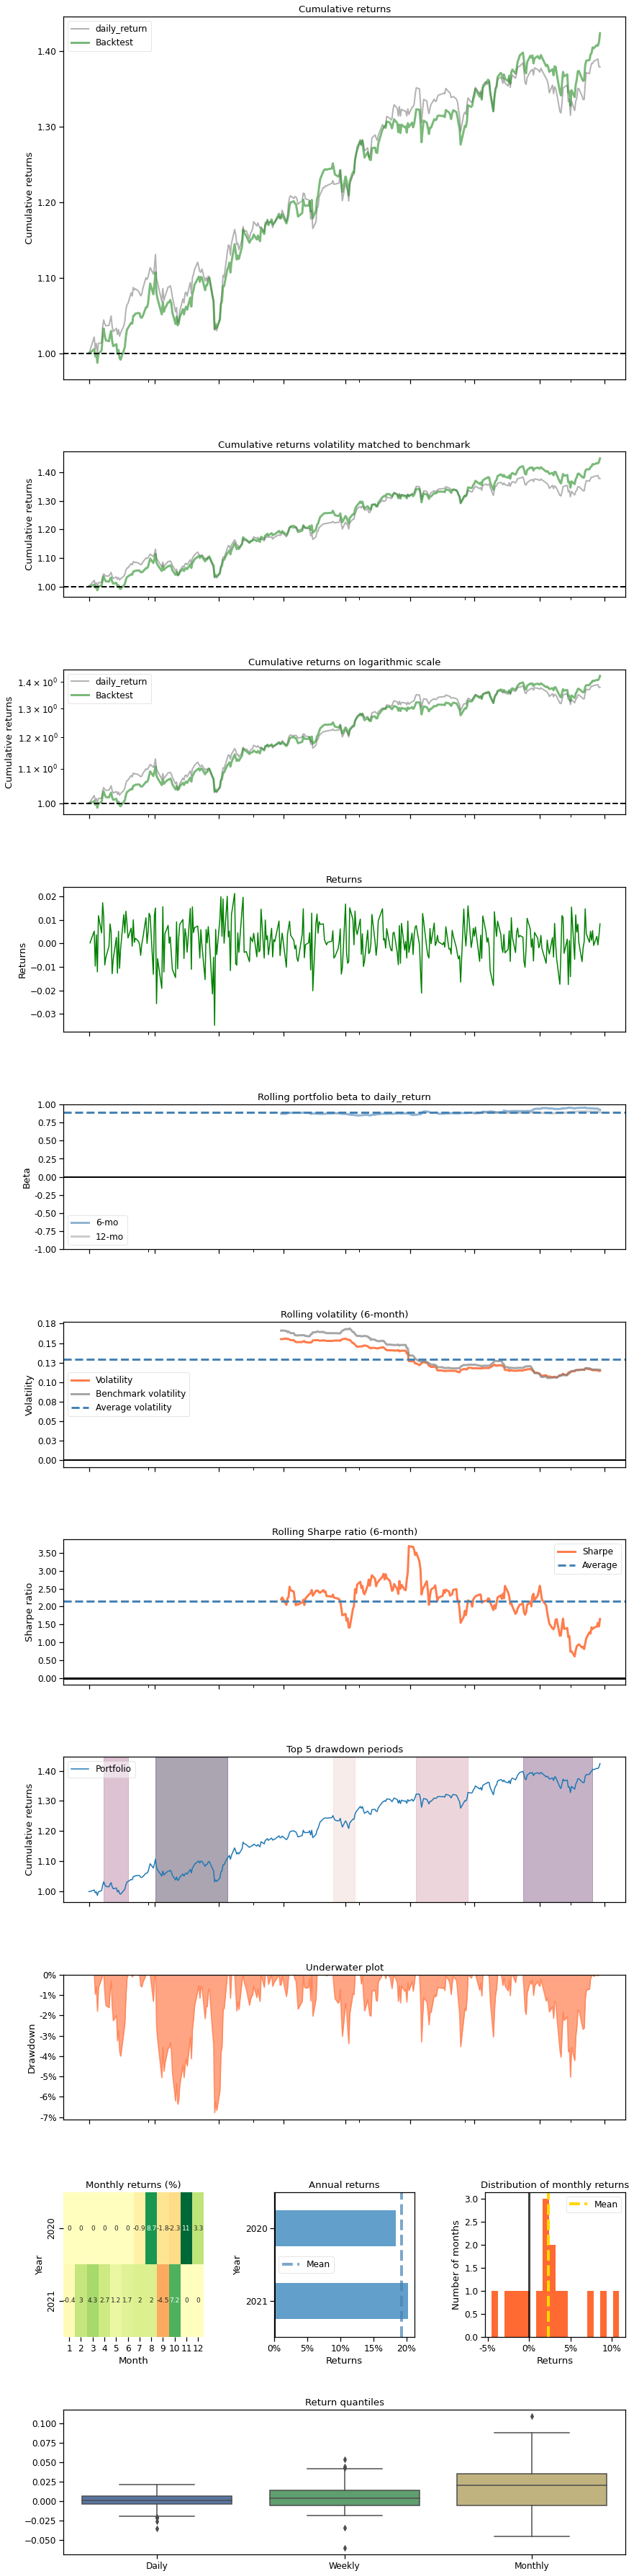

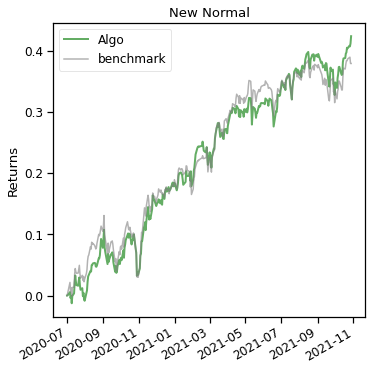

In [30]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])